# 3.1 Classification with a single-layer perceptron

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)
from mlxtend.plotting import plot_decision_regions

## 3.1.1 Generation of linearly-separable data

In [2]:
n = 100
mA = [1,0.5]
sigmaA=0.5
mB = [-1,0]
sigmaB = 0.5
cov = np.eye(2)
classA = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,n)
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

## 3.1.2 Classification with a single-layer perceptron and analysis

### question 1
Apply and compare perceptron learning with the Delta learning rule in batch mode on the generated dataset. Adjust the learning rate and study the convergence of the two algorithms.

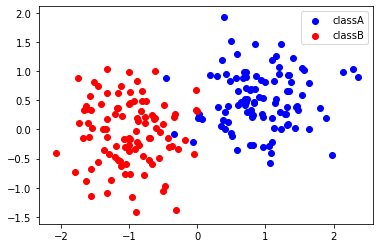

In [3]:
# show the data
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c='blue', label='classA')
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c='red', label='classB')
plt.legend()
plt.show()

### Perceptron

In [4]:
class Perceptron(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X, y):

        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

* boundary

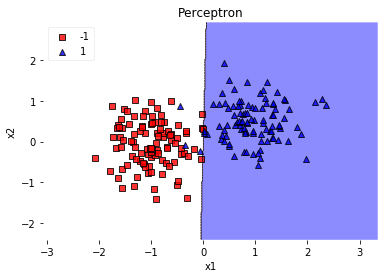

In [5]:
X = inputs
y = targets
EPOCH =20
eta=0.01
ppn = Perceptron(epochs=EPOCH, eta=eta)
ppn.train(X, y)
plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
plt.title('Perceptron')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/perceptron_boundary_eta{}.png'.format(str(eta)))
plt.show()

* converge

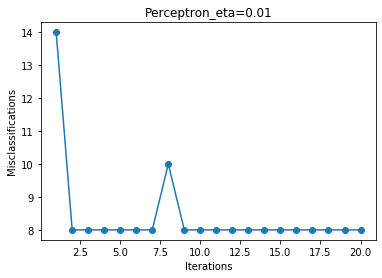

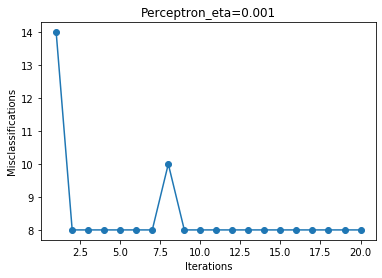

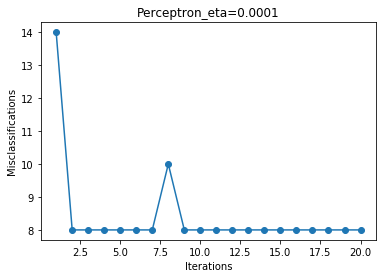

In [6]:
for eta in [0.01,0.001,0.0001]:
    ppn = Perceptron(epochs=EPOCH, eta=eta)
    ppn.train(X, y)
    plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Misclassifications')
    plt.title("Perceptron_eta="+str(eta))
    plt.savefig('imgs/perceptron_converge_eta{}.png'.format(str(eta)))
    plt.show()

### Delta rule (GD)

In [7]:
class AdalineGD(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.epochs):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

* diverge and converge

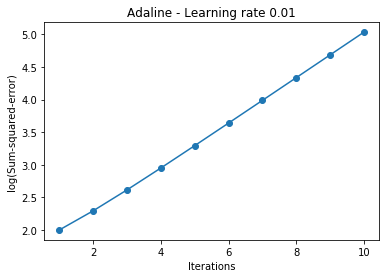

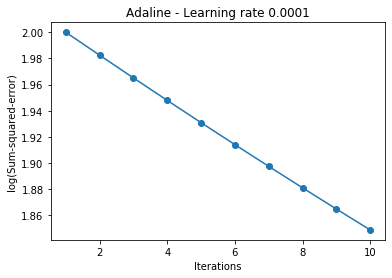

In [8]:
for eta in [0.01,0.0001]:
    ada = AdalineGD(epochs=10, eta=eta).train(X, y)
    plt.plot(range(1, len(ada.cost_)+1), np.log10(ada.cost_), marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('log(Sum-squared-error)')
    plt.title('Adaline - Learning rate {}'.format(str(eta)))
    plt.savefig('imgs/delta_effect_eta{}.png'.format(str(eta)))
    plt.show()

* boundary

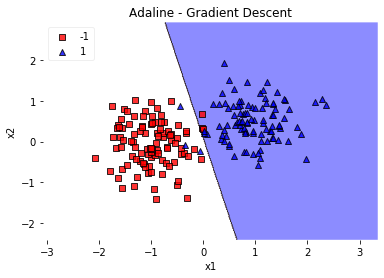

In [9]:
ada = AdalineGD(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_boundary_eta{}.png'.format(str(eta)))
plt.show()


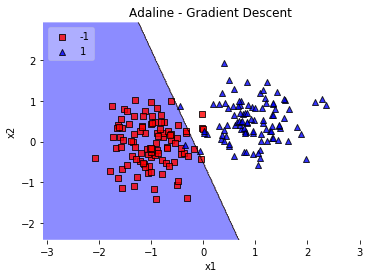

In [10]:
ada = AdalineGD(epochs=20, eta=0.01)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_boundary_eta{}.png'.format(str(eta)))
plt.show()

* converge compare

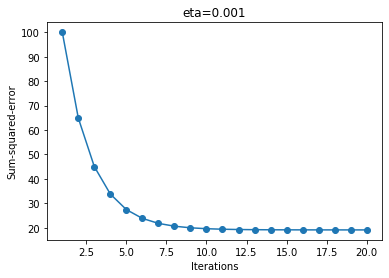

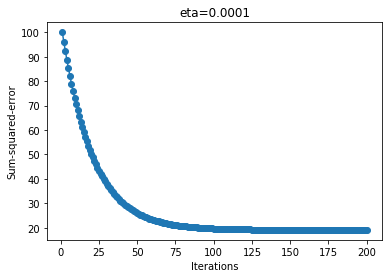

In [11]:
for eta in [0.001,0.0001]:
    ada = AdalineGD(epochs=int(20*0.001/eta), eta=eta)
    ada.train(X, y)
    plt.plot(range(1, len( ada.cost_)+1), ada.cost_, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Sum-squared-error')
    plt.title('eta={}'.format(str(eta)))
    plt.savefig('imgs/delta_convergence_eta{}.png'.format(str(eta)))
    plt.show()
    

### question 2
Compare sequential with a batch learning approach for the Delta rule. How quickly (in terms of epochs) do the algorithms
converge? Please adjust the learning rate and plot the learning curves for each variant. Bear in mind that for 
sequential learning you should not use the matrix form of the learning rule discussed in section 2.2 and instead perform
 updates iteratively for each sample. How sensitive is learning to random initialisation?

* sequential

In [12]:
class AdalineGD_sequential(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = 0

    def train(self, X, y):
        # no reinitials
        
        for i in range(self.epochs):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost=cost
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)


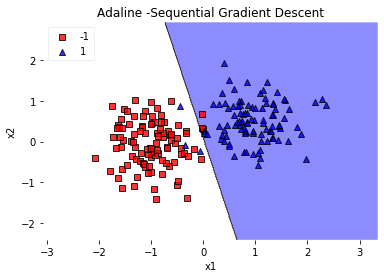

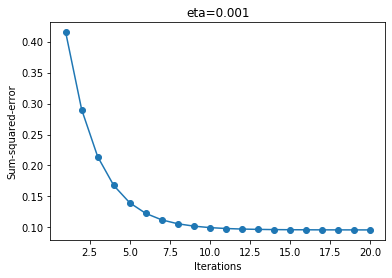

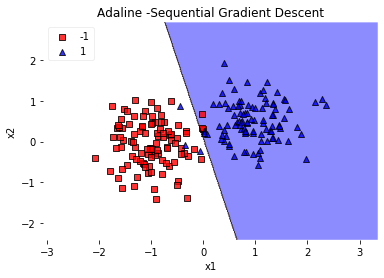

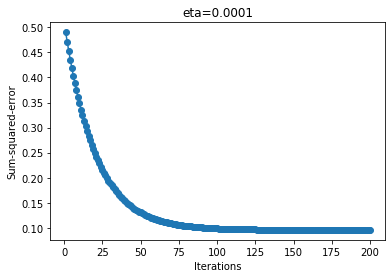

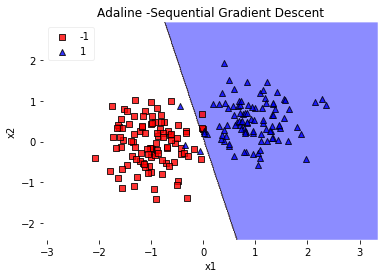

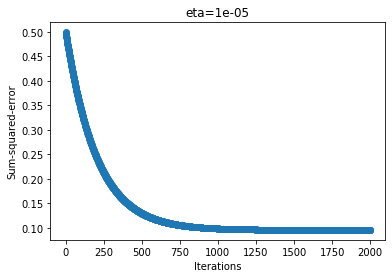

In [13]:
for eta in [0.001,0.0001,0.00001]:
    ada = AdalineGD_sequential(eta=eta,epochs=1)
    epochs = int(20*0.001/eta)
    costs = []
    for epoch in range(epochs):
        cost=[]
        #shuffle
        permute = list(range(N))
        np.random.shuffle(permute)
        X = X[permute, :]
        y = y[permute]
        #train
        for ri in range(N):
            ada.train(X[ri].reshape(1,2),y[ri])
            cost.append(ada.cost)
        costs.append(np.mean(cost))   
    plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
    plt.title('Adaline -Sequential Gradient Descent')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('imgs/sequential_boundary_eta{}.png'.format(str(eta)))
    plt.show()
    plt.plot(range(1, epochs+1), costs, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Sum-squared-error')
    plt.title('eta={}'.format(str(eta)))
    plt.savefig('imgs/sequential_eta{}.png'.format(str(eta)))
    plt.show()

### question 3
Remove the bias, train your network with the Delta rule in batch mode and test its behaviour. In what cases would the perceptron without bias converge and classify correctly all data samples? Please verify your hypothesis by adjusting data parameters, mA and mB.

In [14]:
class AdalineGD_unbiased(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X, y):
        self.w_ = np.zeros( X.shape[1])
        self.cost_ = []

        for i in range(self.epochs):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors)
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_)

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)



* different side of (0,0)

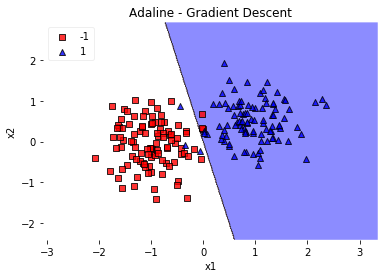

In [15]:
ada = AdalineGD_unbiased(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_unbiased_eta{}.png'.format(str(eta)))
plt.show()

* same side of (0,0)

In [16]:
mA = [1,1]
sigmaA=0.5
mB = [2,2]
sigmaB = 0.5
cov = np.eye(2)
classA = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,n)
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

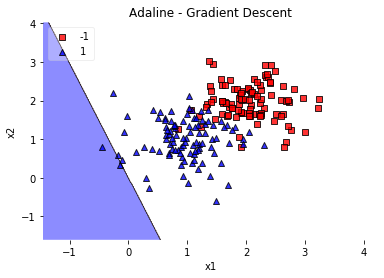

In [17]:
X = inputs
y = targets
ada = AdalineGD_unbiased(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_unbiased_eta{}.png'.format(str(eta)))
plt.show()

## 3.1.3 Classification of samples that are not linearly separable

### overlap

In [18]:
mA = [1,1]
sigmaA = 0.5
mB = [1.8,1.8]
sigmaB = 0.5
cov = np.eye(2)
classA = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,n)
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

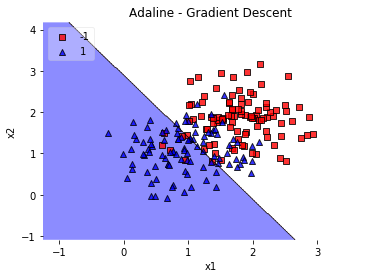

In [19]:
X=inputs
y=targets

ada = AdalineGD(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_overlap_eta{}.png'.format(str(eta)))
plt.show()

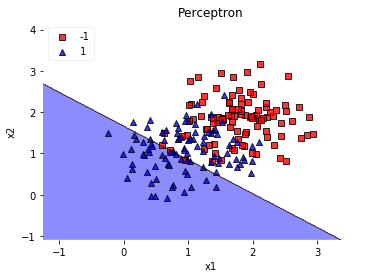

In [20]:
ppn = Perceptron(epochs=EPOCH, eta=eta)
ppn.train(X, y)
plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
plt.title('Perceptron')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/perceptron_overlap_eta{}.png'.format(str(eta)))
plt.show()

### Linearly non-separable dataset

In [21]:
mA = [1,0.3]
sigmaA=0.2
mB = [0,-0.1]
sigmaB = 0.3
cov = np.eye(2)
classA1 = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,50)
classA2 = np.random.multivariate_normal([-1,0.3],sigmaA*sigmaA*cov,50)
classA = np.concatenate((classA1,classA2))
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

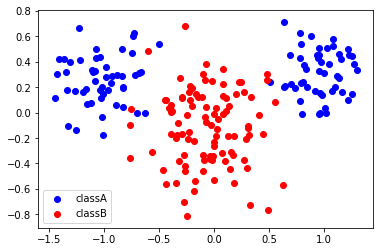

In [22]:
# show the data
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c='blue', label='classA')
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c='red', label='classB')
plt.legend()
plt.show()

* random 25% from each class

In [23]:
# make the data random
np.random.seed()
iters =100

random 25% from each class


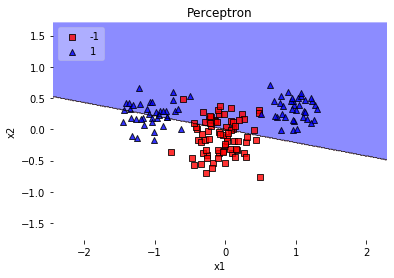

precision:
classA:0.7866666666666666
classB:0.6133333333333333


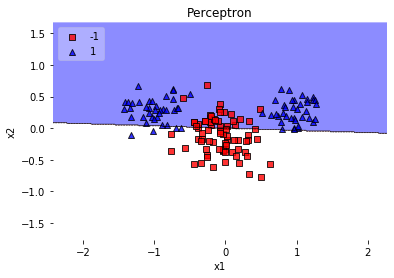

precision:
classA:0.9466666666666667
classB:0.6266666666666667


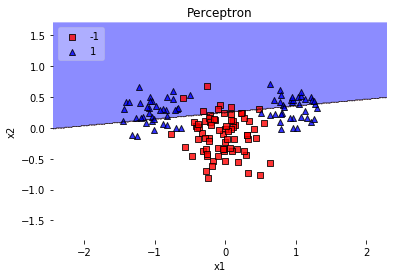

precision:
classA:0.64
classB:0.8933333333333333


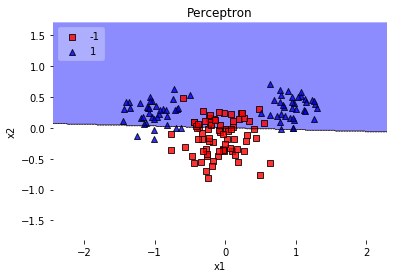

precision:
classA:0.9333333333333333
classB:0.64


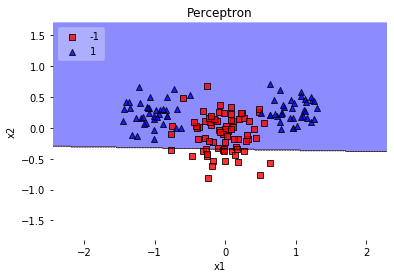

precision:
classA:1.0
classB:0.22666666666666666


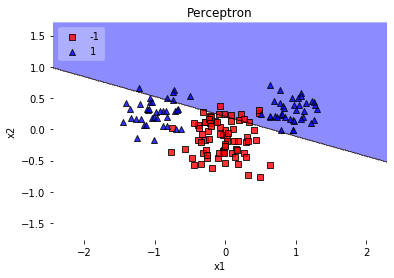

precision:
classA:0.5733333333333334
classB:0.8666666666666667


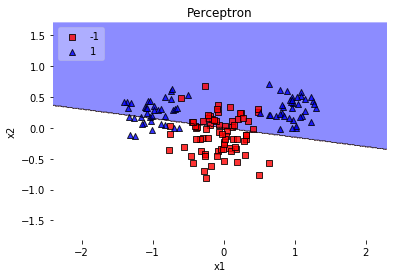

precision:
classA:0.84
classB:0.6133333333333333


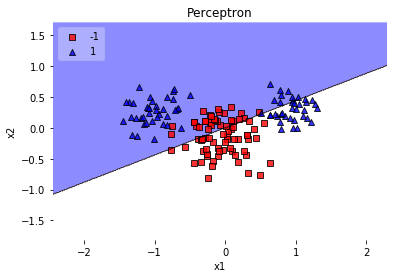

precision:
classA:0.6533333333333333
classB:0.6133333333333333


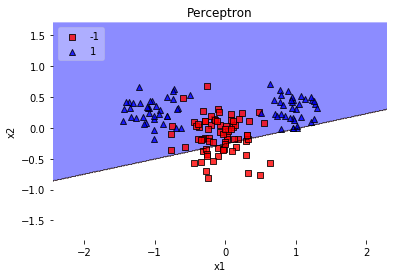

precision:
classA:1.0
classB:0.29333333333333333


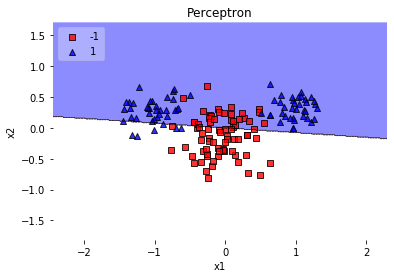

precision:
classA:0.9066666666666666
classB:0.6266666666666667


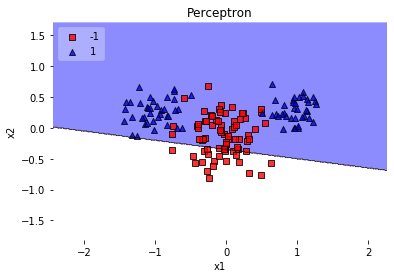

precision:
classA:1.0
classB:0.26666666666666666


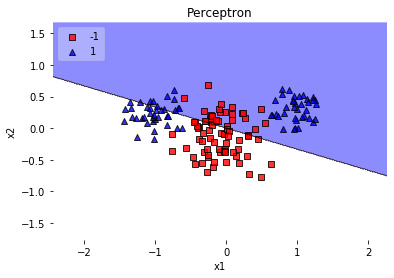

precision:
classA:0.64
classB:0.6666666666666666


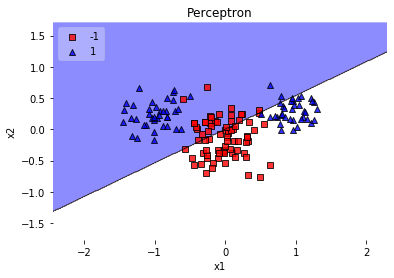

precision:
classA:0.5466666666666666
classB:0.6533333333333333


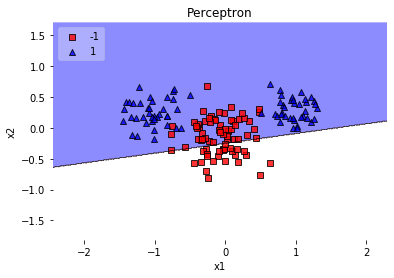

precision:
classA:1.0
classB:0.3333333333333333


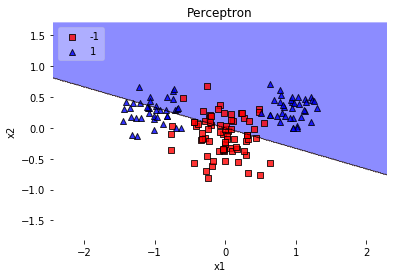

precision:
classA:0.6666666666666666
classB:0.6666666666666666


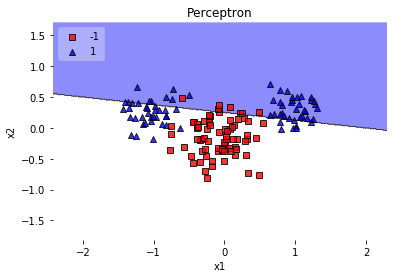

precision:
classA:0.5333333333333333
classB:0.9066666666666666


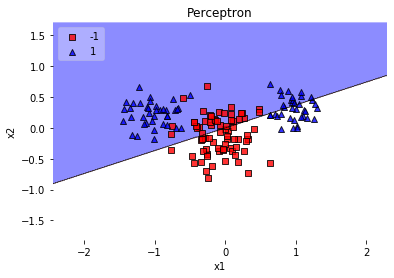

precision:
classA:0.6933333333333334
classB:0.56


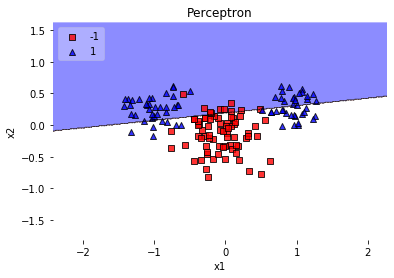

precision:
classA:0.6533333333333333
classB:0.8666666666666667


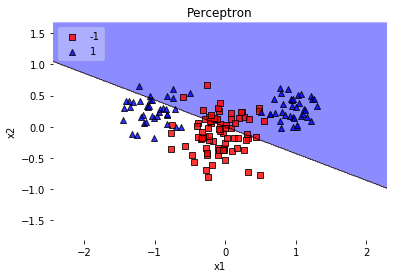

precision:
classA:0.5733333333333334
classB:0.6266666666666667


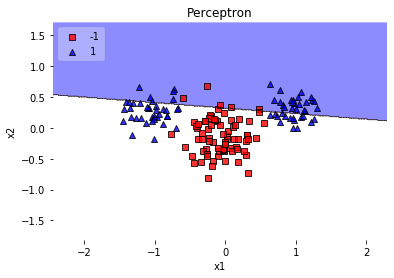

precision:
classA:0.37333333333333335
classB:0.9333333333333333


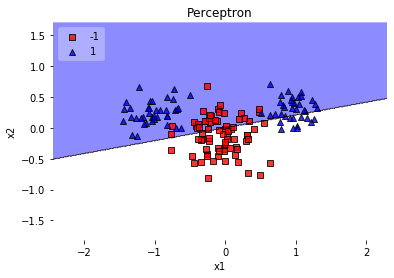

precision:
classA:0.8533333333333334
classB:0.6133333333333333


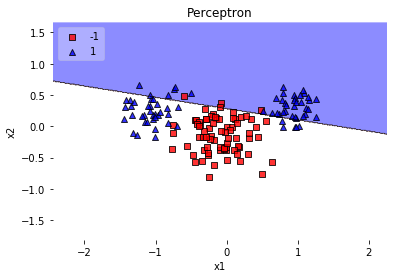

precision:
classA:0.5066666666666667
classB:0.9466666666666667


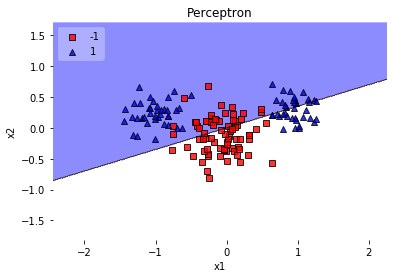

precision:
classA:0.7333333333333333
classB:0.6


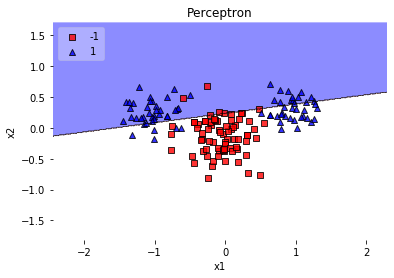

precision:
classA:0.6266666666666667
classB:0.9333333333333333


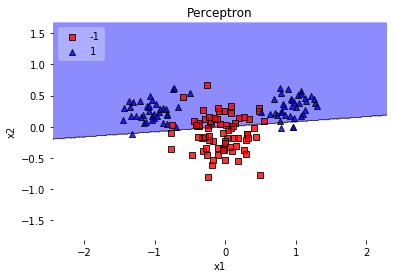

precision:
classA:0.9466666666666667
classB:0.5866666666666667


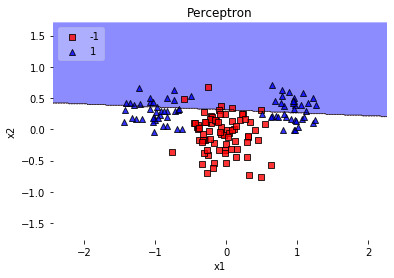

precision:
classA:0.4266666666666667
classB:0.9333333333333333


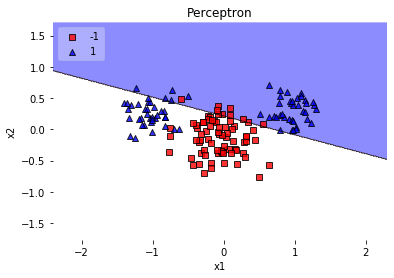

precision:
classA:0.56
classB:0.8666666666666667


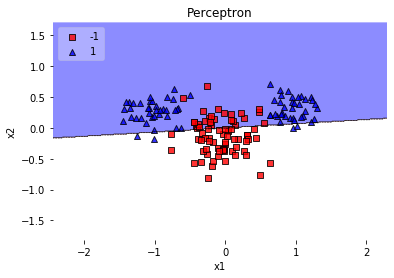

precision:
classA:0.9466666666666667
classB:0.6533333333333333


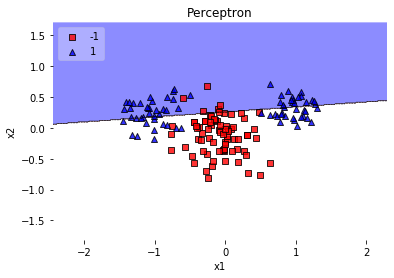

precision:
classA:0.5866666666666667
classB:0.9333333333333333


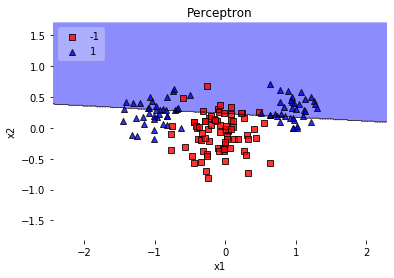

precision:
classA:0.6
classB:0.8533333333333334


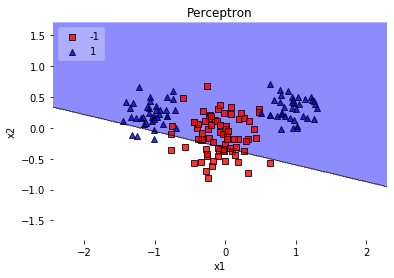

precision:
classA:0.96
classB:0.30666666666666664


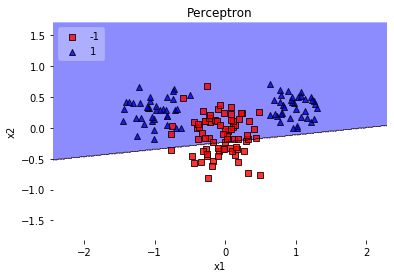

precision:
classA:1.0
classB:0.36


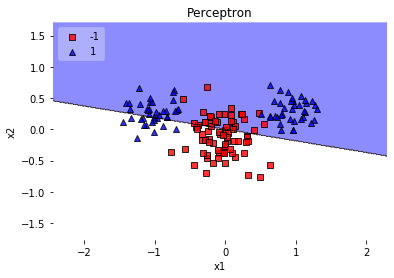

precision:
classA:0.84
classB:0.64


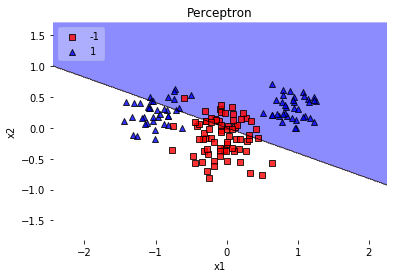

precision:
classA:0.6
classB:0.6533333333333333


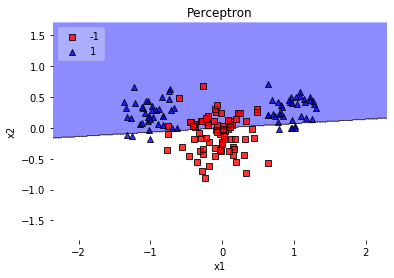

precision:
classA:0.8933333333333333
classB:0.5866666666666667


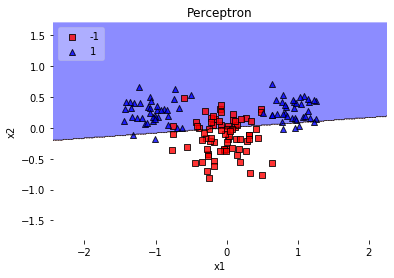

precision:
classA:0.9333333333333333
classB:0.64


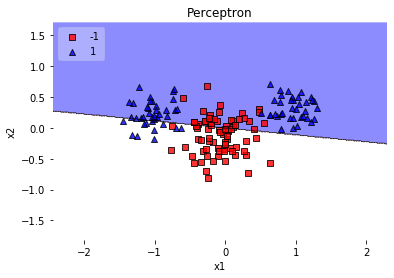

precision:
classA:0.8533333333333334
classB:0.6133333333333333


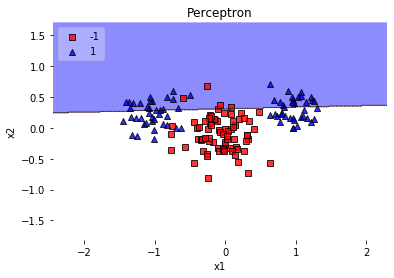

precision:
classA:0.4666666666666667
classB:0.9466666666666667


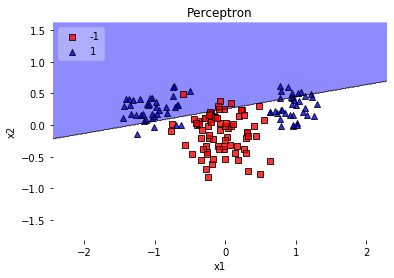

precision:
classA:0.5866666666666667
classB:0.92


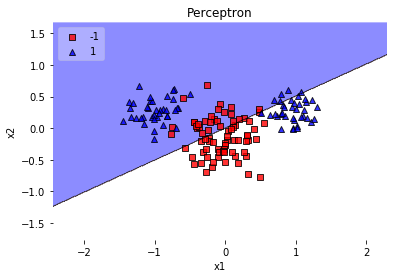

precision:
classA:0.5733333333333334
classB:0.6266666666666667


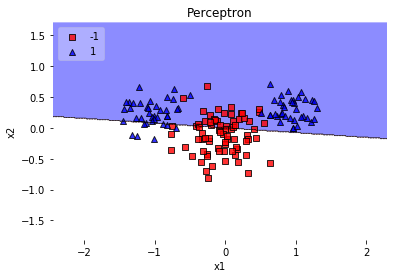

precision:
classA:0.88
classB:0.6


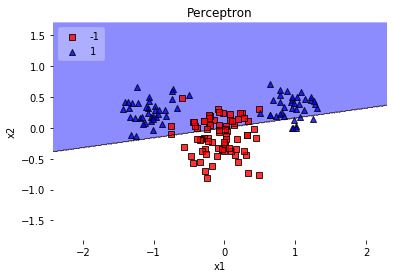

precision:
classA:0.92
classB:0.5866666666666667


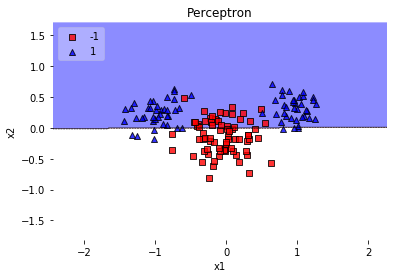

precision:
classA:0.9066666666666666
classB:0.64


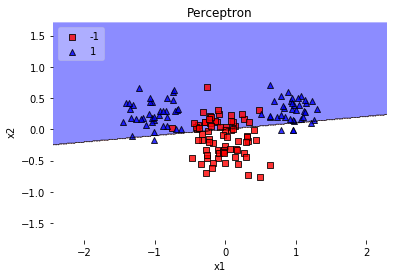

precision:
classA:0.9333333333333333
classB:0.6


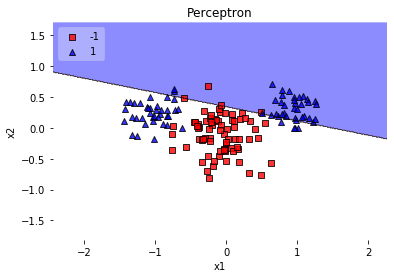

precision:
classA:0.4666666666666667
classB:0.9466666666666667


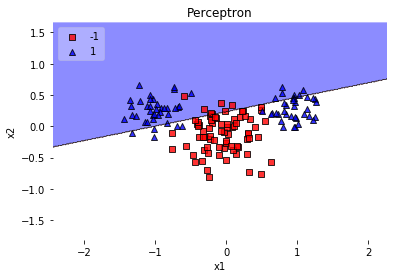

precision:
classA:0.5333333333333333
classB:0.9066666666666666


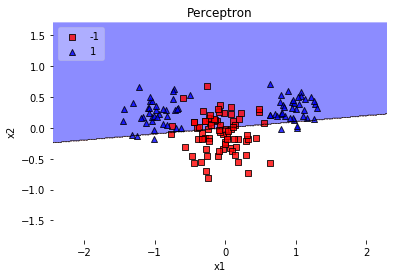

precision:
classA:0.9333333333333333
classB:0.5733333333333334


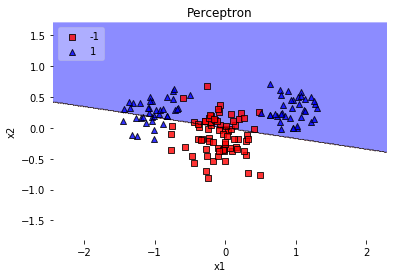

precision:
classA:0.84
classB:0.64


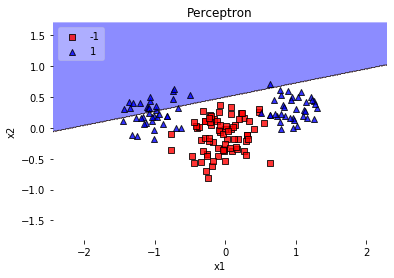

precision:
classA:0.22666666666666666
classB:1.0


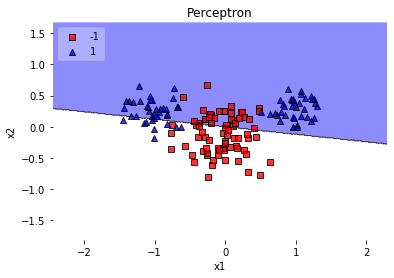

precision:
classA:0.88
classB:0.6133333333333333


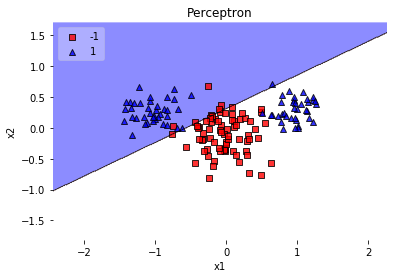

precision:
classA:0.52
classB:0.9066666666666666


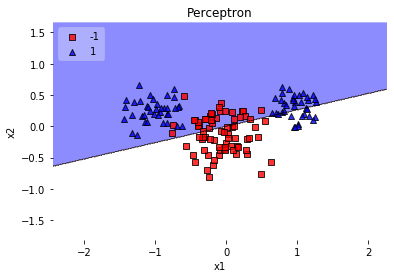

precision:
classA:0.8266666666666667
classB:0.6


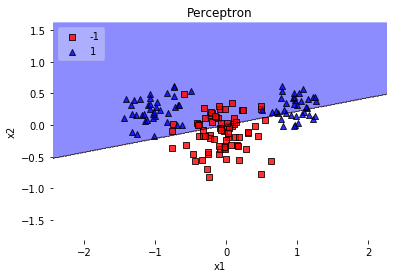

precision:
classA:0.84
classB:0.64


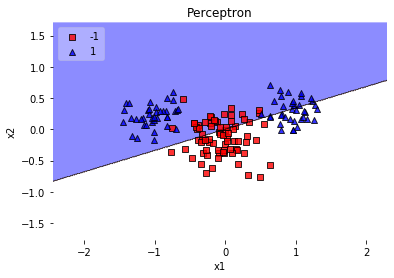

precision:
classA:0.72
classB:0.6133333333333333


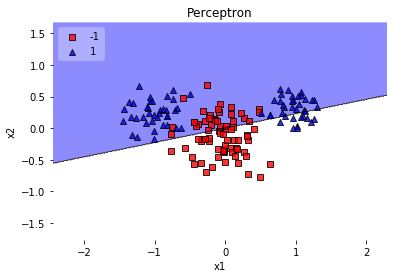

precision:
classA:0.8666666666666667
classB:0.6


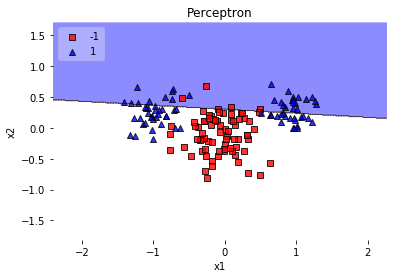

precision:
classA:0.37333333333333335
classB:0.9466666666666667


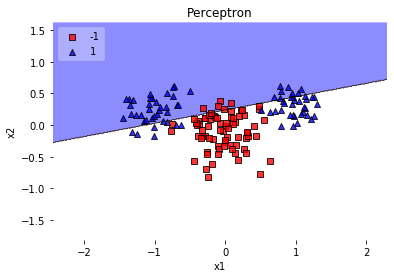

precision:
classA:0.5466666666666666
classB:0.9333333333333333


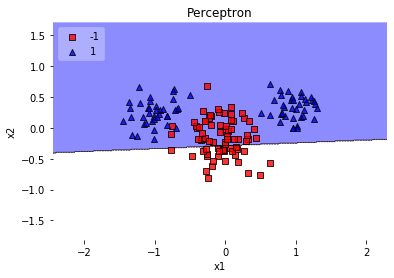

precision:
classA:1.0
classB:0.36


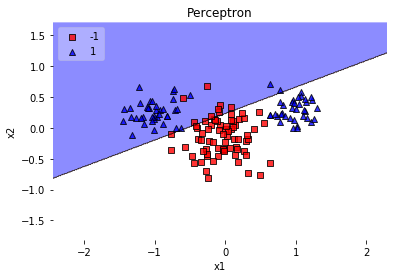

precision:
classA:0.5333333333333333
classB:0.88


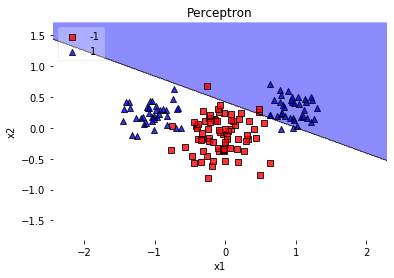

precision:
classA:0.4666666666666667
classB:0.96


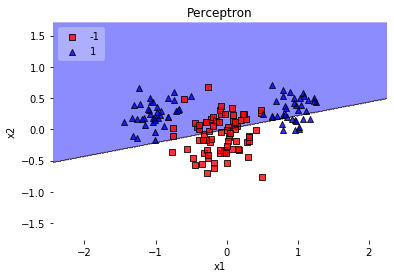

precision:
classA:0.8666666666666667
classB:0.5733333333333334


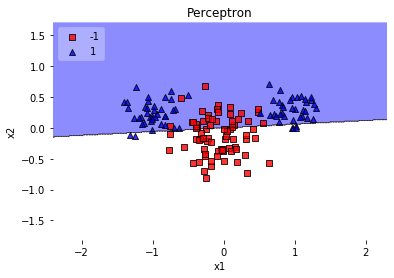

precision:
classA:0.92
classB:0.6133333333333333


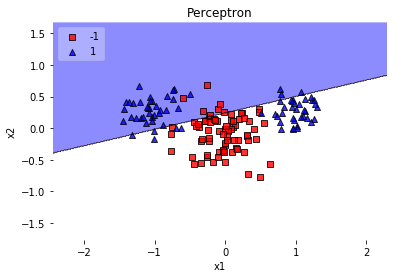

precision:
classA:0.48
classB:0.9066666666666666


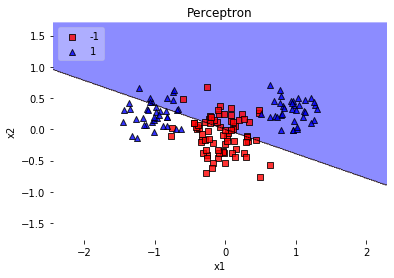

precision:
classA:0.6266666666666667
classB:0.6


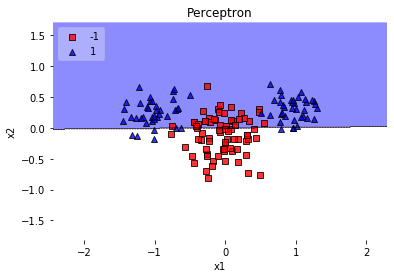

precision:
classA:0.9066666666666666
classB:0.5866666666666667


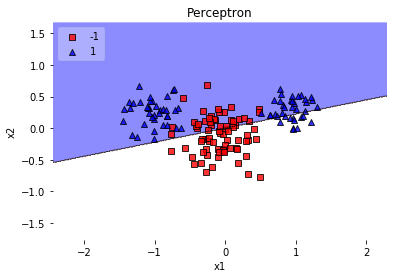

precision:
classA:0.8666666666666667
classB:0.5866666666666667


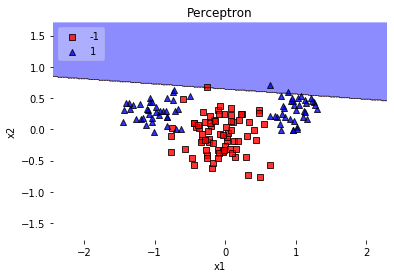

precision:
classA:0.02666666666666667
classB:0.9866666666666667


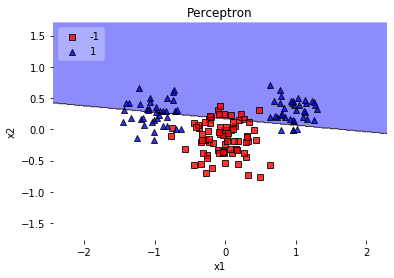

precision:
classA:0.7066666666666667
classB:0.8666666666666667


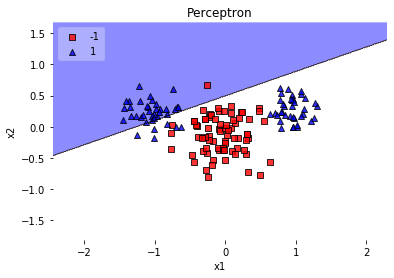

precision:
classA:0.4266666666666667
classB:0.9866666666666667


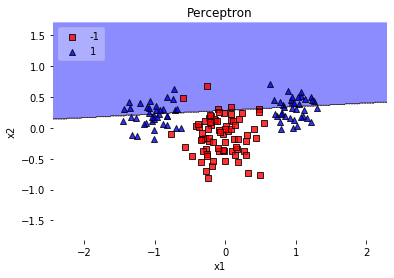

precision:
classA:0.48
classB:0.9466666666666667


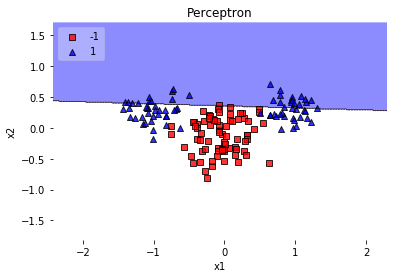

precision:
classA:0.37333333333333335
classB:0.9866666666666667


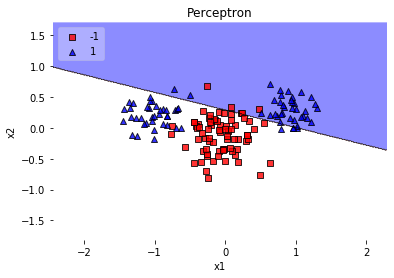

precision:
classA:0.4666666666666667
classB:0.9333333333333333


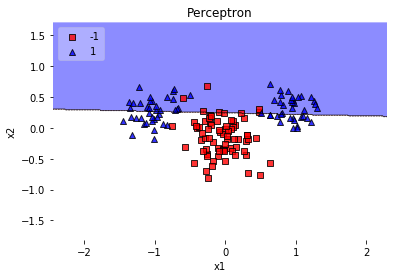

precision:
classA:0.5866666666666667
classB:0.9066666666666666


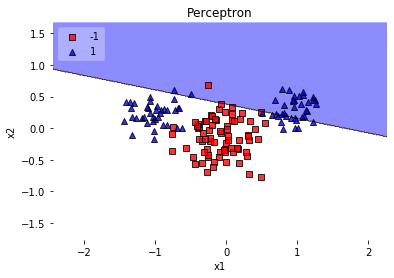

precision:
classA:0.37333333333333335
classB:0.9866666666666667


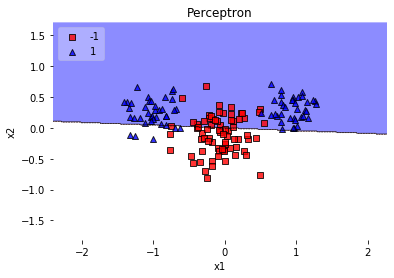

precision:
classA:0.9333333333333333
classB:0.6266666666666667


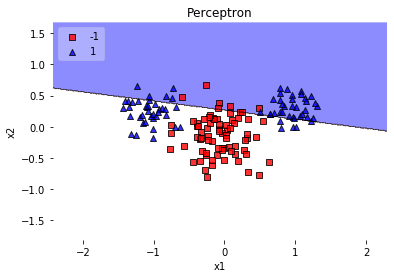

precision:
classA:0.52
classB:0.8933333333333333


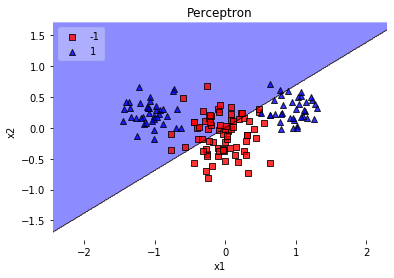

precision:
classA:0.5333333333333333
classB:0.5733333333333334


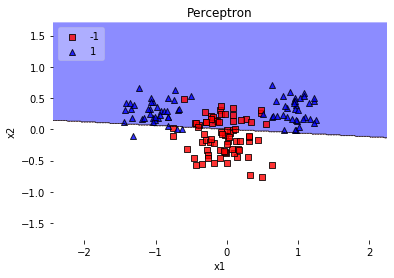

precision:
classA:0.9466666666666667
classB:0.6133333333333333


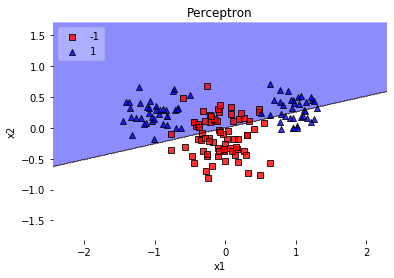

precision:
classA:0.7866666666666666
classB:0.6133333333333333


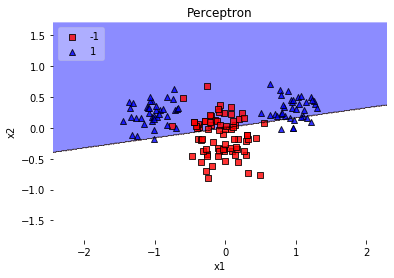

precision:
classA:0.8933333333333333
classB:0.5866666666666667


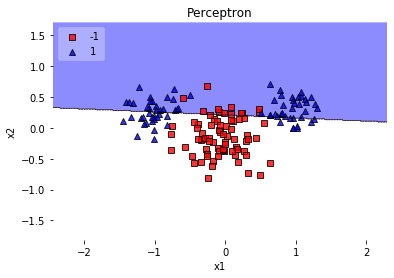

precision:
classA:0.6533333333333333
classB:0.84


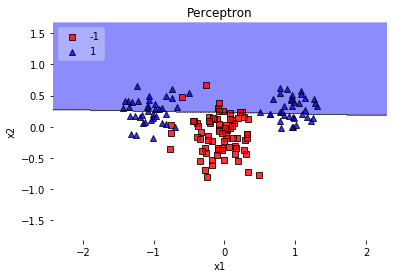

precision:
classA:0.56
classB:0.8933333333333333


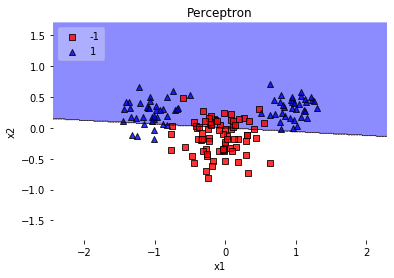

precision:
classA:0.92
classB:0.6666666666666666


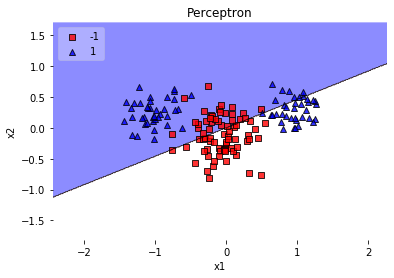

precision:
classA:0.6266666666666667
classB:0.6


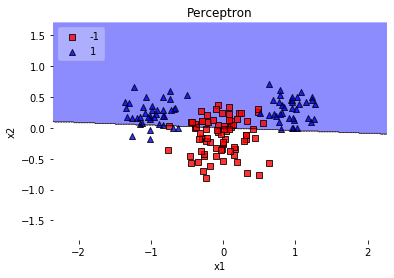

precision:
classA:0.9333333333333333
classB:0.6266666666666667


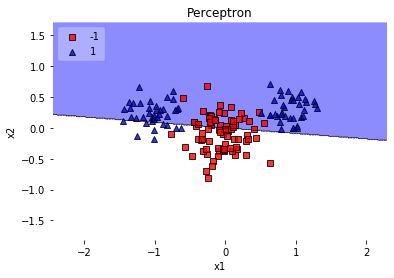

precision:
classA:0.88
classB:0.6


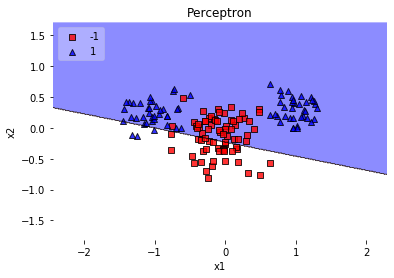

precision:
classA:0.96
classB:0.4266666666666667


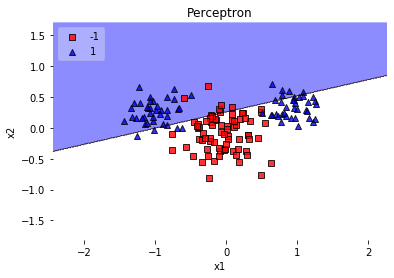

precision:
classA:0.5333333333333333
classB:0.9066666666666666


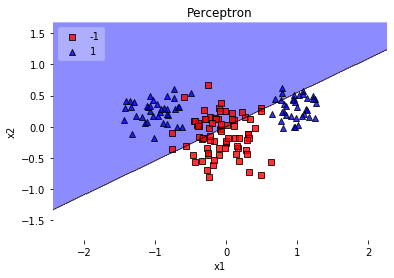

precision:
classA:0.56
classB:0.5466666666666666


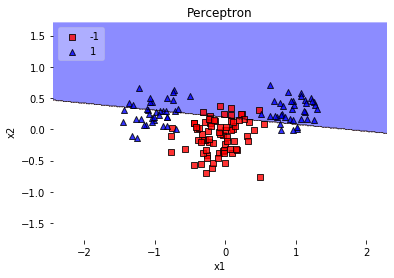

precision:
classA:0.64
classB:0.8933333333333333


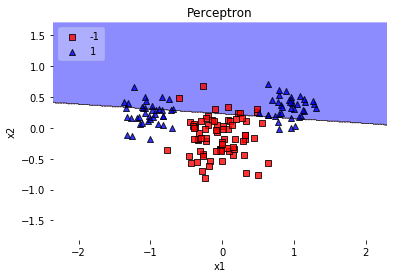

precision:
classA:0.6266666666666667
classB:0.8933333333333333


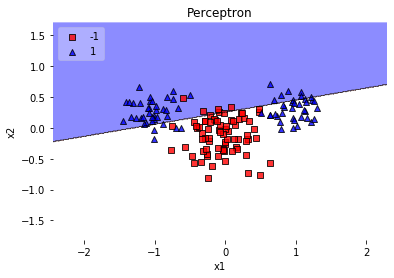

precision:
classA:0.5466666666666666
classB:0.9333333333333333


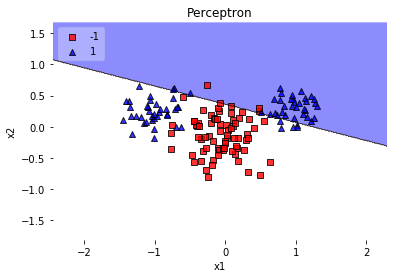

precision:
classA:0.4666666666666667
classB:0.9466666666666667


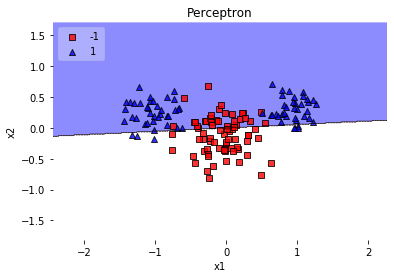

precision:
classA:0.9066666666666666
classB:0.6


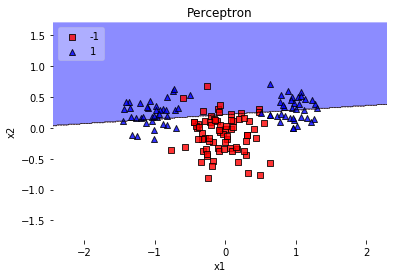

precision:
classA:0.64
classB:0.8666666666666667


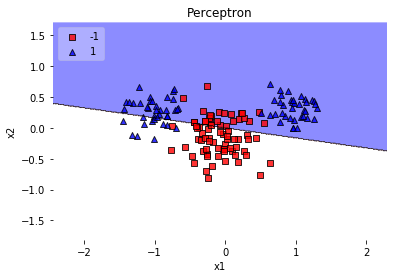

precision:
classA:0.8533333333333334
classB:0.6533333333333333


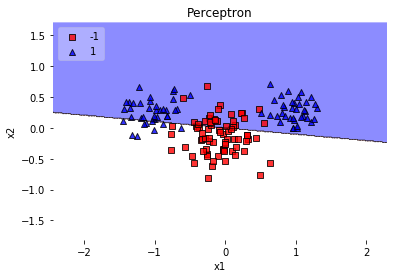

precision:
classA:0.8933333333333333
classB:0.68


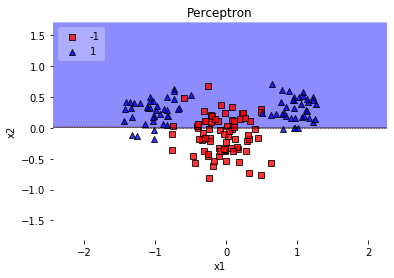

precision:
classA:0.9066666666666666
classB:0.6266666666666667


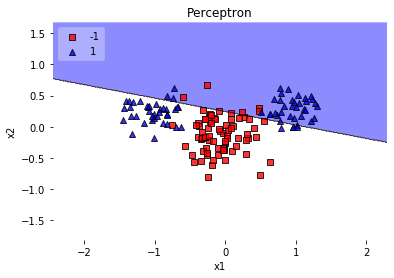

precision:
classA:0.48
classB:0.9333333333333333


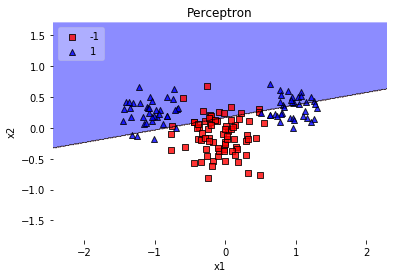

precision:
classA:0.6933333333333334
classB:0.8


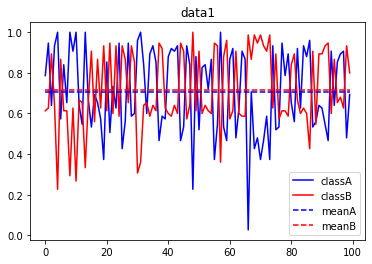

In [24]:
print('random 25% from each class')
resultsA = []
resultsB = []

for ri in range(iters):
    A1=classA1
    np.random.shuffle(A1)
    A1=A1[0:37]
    A2 = classA2
    np.random.shuffle(A2)
    A2=A2[0:38]
    A=np.concatenate((A1,A2))
    B=classB
    np.random.shuffle(B)
    B =B[0:75]
    inputs = np.concatenate((A, B))
    targets = np.concatenate((np.ones(A.shape[0],dtype=int), -np.ones(B.shape[0],dtype=int)))
    N = inputs.shape[0]  # Number of rows (samples)
    permute = list(range(N))
    np.random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]


    X = inputs
    y = targets
    ppn = Perceptron(epochs=20, eta=0.01)
    ppn.train(X, y)
    plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
    plt.title('Perceptron')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('imgs/unseen_data1_eta{}_iter{}.png'.format(str(eta),ri))
    plt.show()


    a = 0
    b = 0
    for x,t in zip(inputs,targets):
        if ppn.predict(x)==t:
            if t == 1:
                a=a+1
            if t ==-1:
                b=b+1
    print('precision:')
    print('classA:'+str(a/len(A)))
    print('classB:'+str(b/len(B)))
    resultsA.append(a/len(A))
    resultsB.append(b/len(B))
x = [i for i in range(iters)]
plt.plot(x,resultsA,'b-',label='classA')
plt.plot(x,resultsB,'r-',label='classB')
A_mean = [np.mean(resultsA)]*len(x)
B_mean = [np.mean(resultsB)]*len(x)
plt.plot(x,A_mean, label='meanA', linestyle='--',c='b')
plt.plot(x,B_mean, label='meanB', linestyle='--',c='r')
plt.legend()
plt.title('data1')
plt.savefig('imgs/data1_precision.png')
plt.show()
    

* random 50% from classA

random 50% from classA


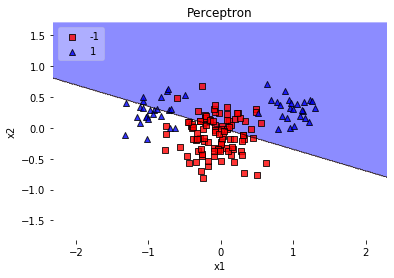

precision:
classA:0.66
classB:0.65


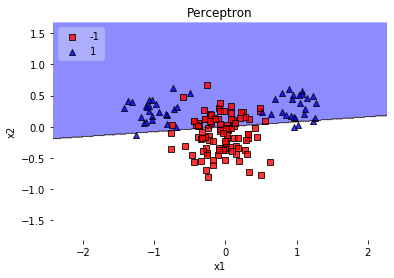

precision:
classA:0.92
classB:0.6


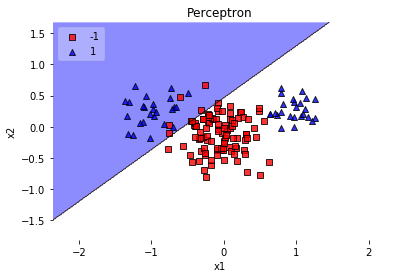

precision:
classA:0.5
classB:0.94


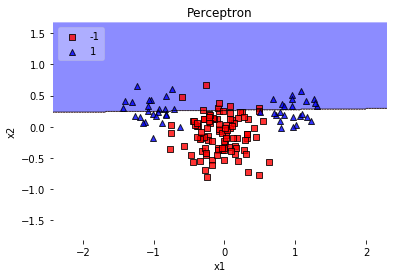

precision:
classA:0.46
classB:0.93


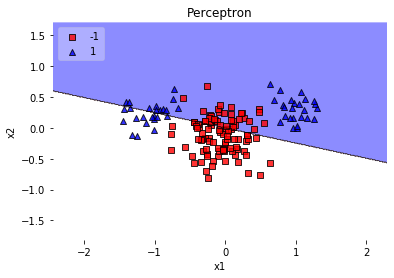

precision:
classA:0.72
classB:0.65


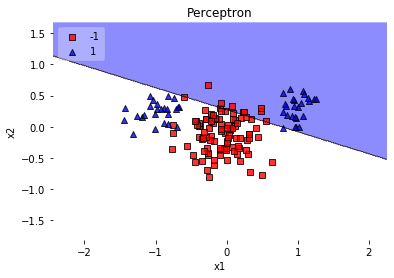

precision:
classA:0.48
classB:0.91


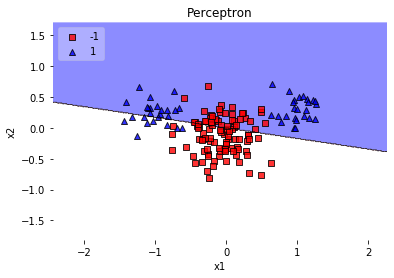

precision:
classA:0.82
classB:0.63


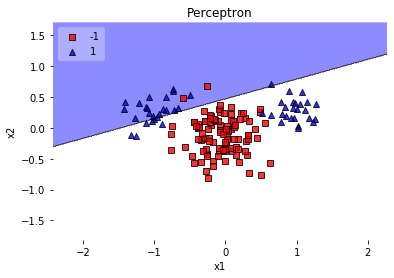

precision:
classA:0.4
classB:0.98


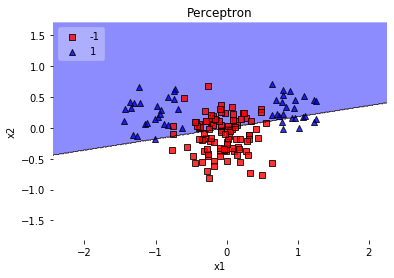

precision:
classA:0.86
classB:0.6


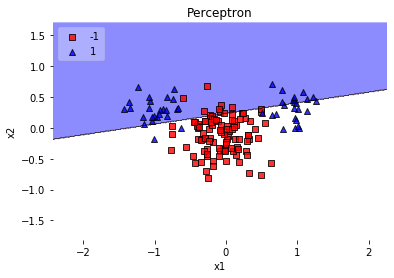

precision:
classA:0.66
classB:0.91


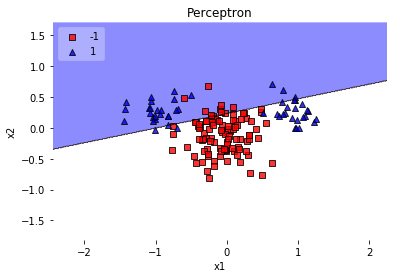

precision:
classA:0.54
classB:0.9


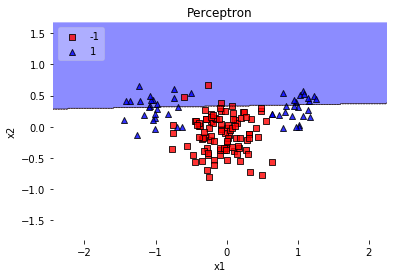

precision:
classA:0.46
classB:0.96


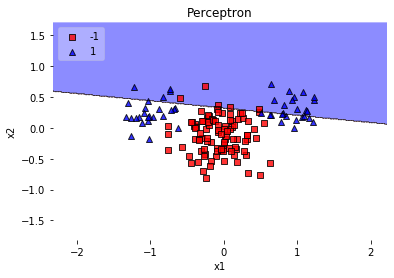

precision:
classA:0.38
classB:0.95


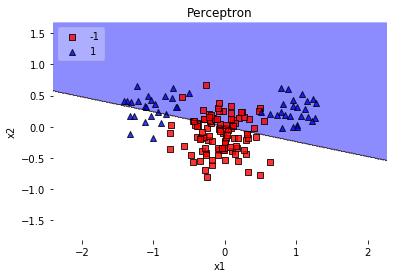

precision:
classA:0.86
classB:0.65


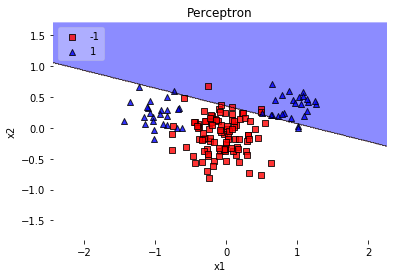

precision:
classA:0.48
classB:0.95


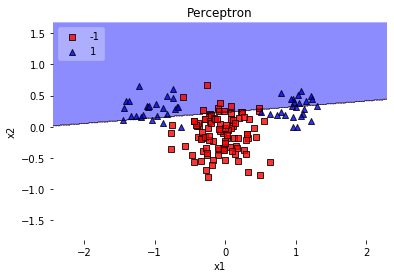

precision:
classA:0.66
classB:0.91


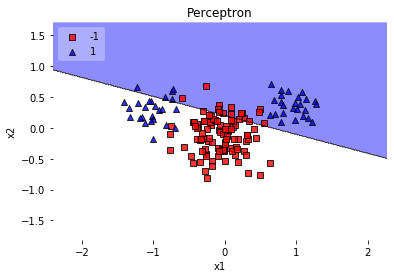

precision:
classA:0.6
classB:0.84


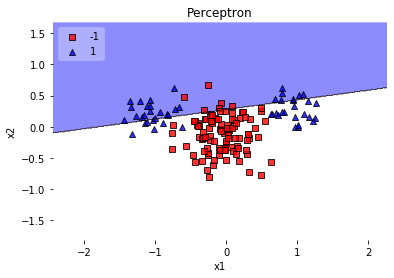

precision:
classA:0.52
classB:0.94


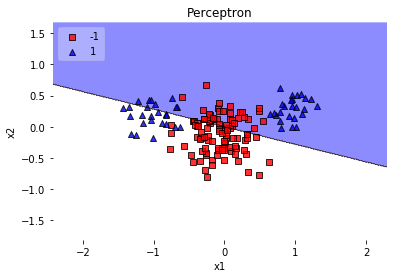

precision:
classA:0.66
classB:0.66


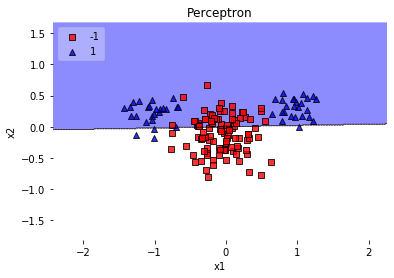

precision:
classA:0.92
classB:0.6


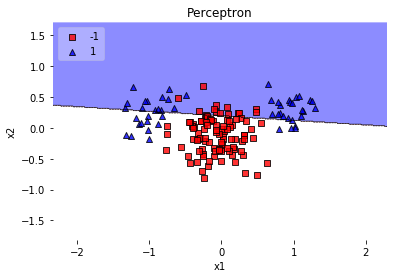

precision:
classA:0.7
classB:0.87


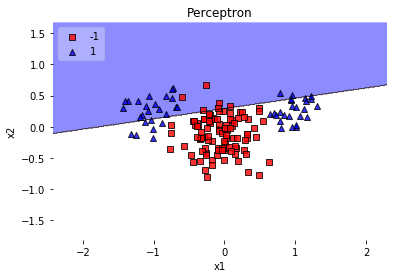

precision:
classA:0.44
classB:0.94


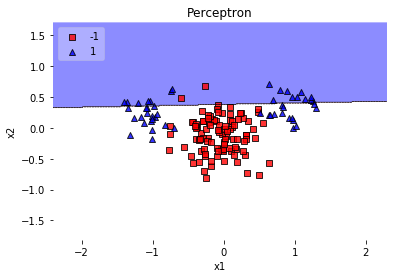

precision:
classA:0.36
classB:0.98


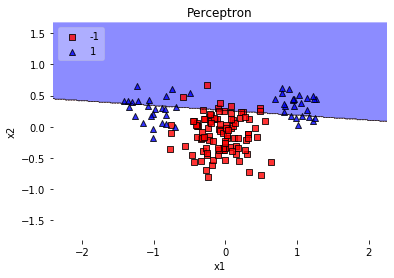

precision:
classA:0.54
classB:0.93


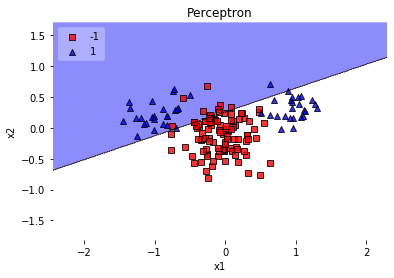

precision:
classA:0.54
classB:0.87


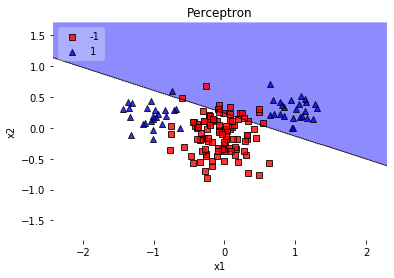

precision:
classA:0.52
classB:0.86


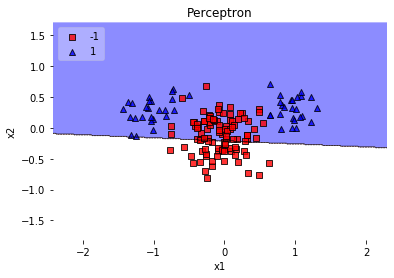

precision:
classA:1.0
classB:0.37


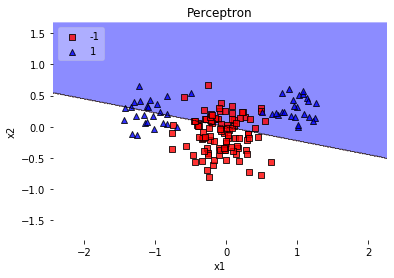

precision:
classA:0.74
classB:0.64


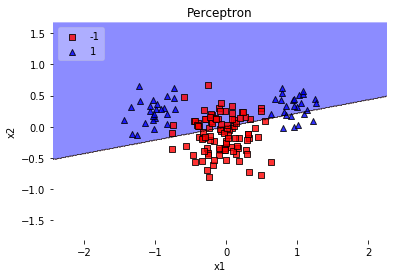

precision:
classA:0.88
classB:0.6


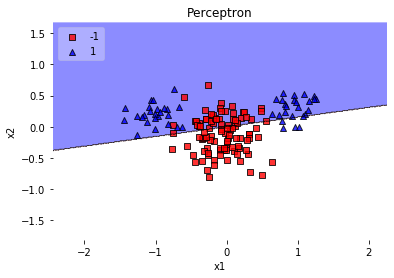

precision:
classA:0.92
classB:0.6


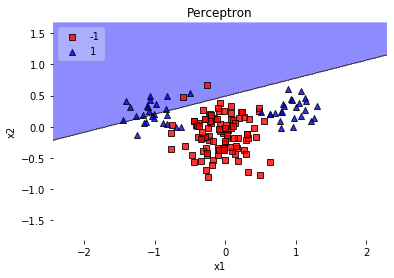

precision:
classA:0.3
classB:0.98


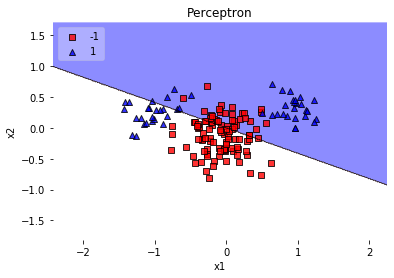

precision:
classA:0.62
classB:0.65


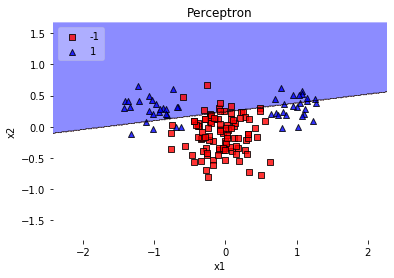

precision:
classA:0.6
classB:0.91


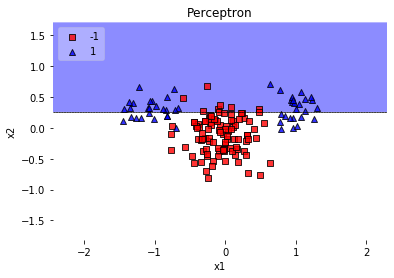

precision:
classA:0.62
classB:0.93


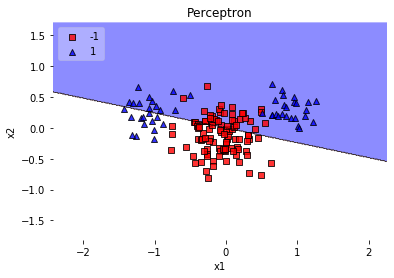

precision:
classA:0.74
classB:0.65


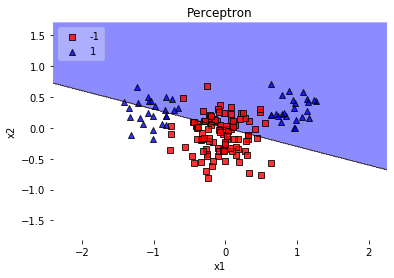

precision:
classA:0.72
classB:0.66


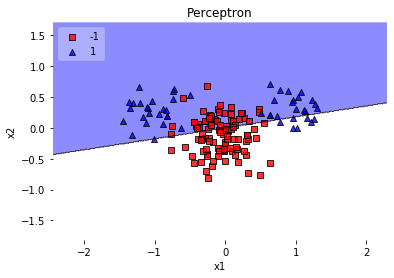

precision:
classA:0.86
classB:0.6


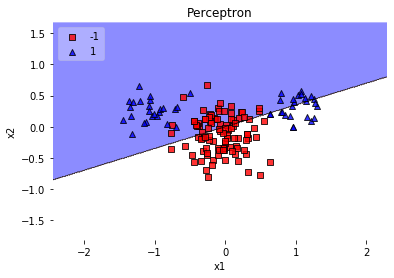

precision:
classA:0.72
classB:0.59


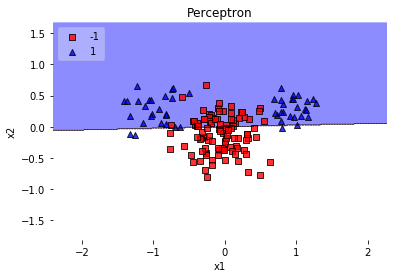

precision:
classA:0.94
classB:0.6


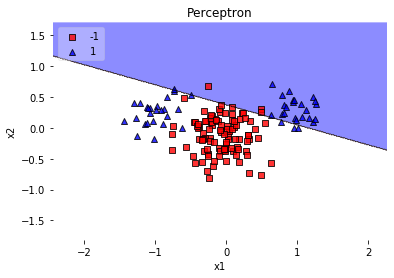

precision:
classA:0.48
classB:0.97


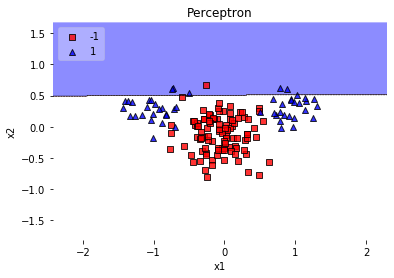

precision:
classA:0.1
classB:0.99


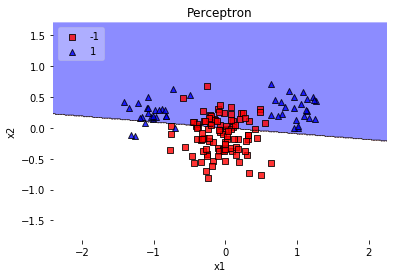

precision:
classA:0.92
classB:0.63


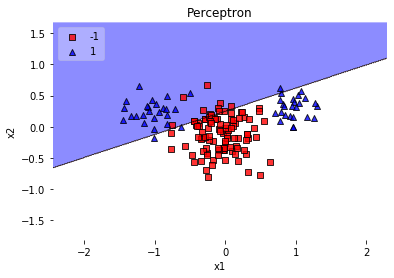

precision:
classA:0.48
classB:0.87


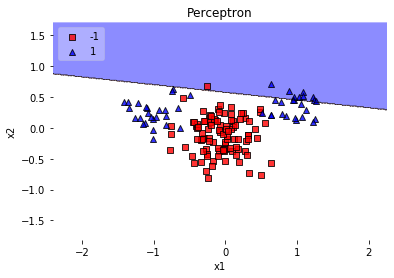

precision:
classA:0.18
classB:0.99


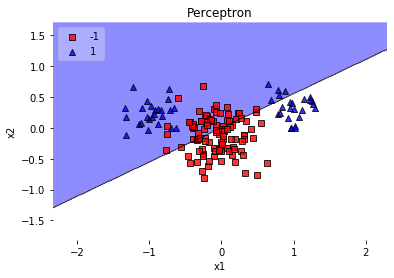

precision:
classA:0.6
classB:0.58


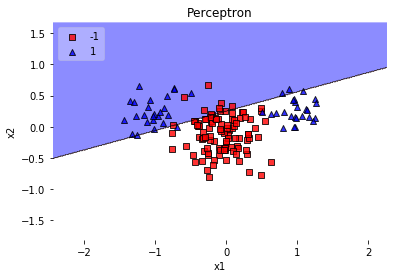

precision:
classA:0.52
classB:0.89


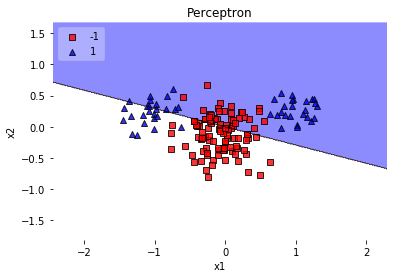

precision:
classA:0.72
classB:0.66


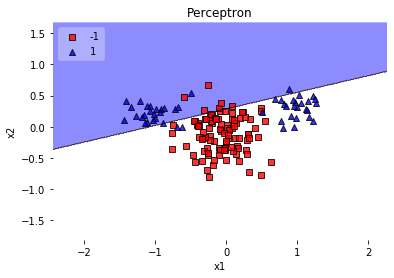

precision:
classA:0.48
classB:0.94


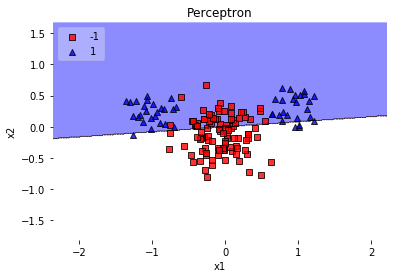

precision:
classA:0.9
classB:0.6


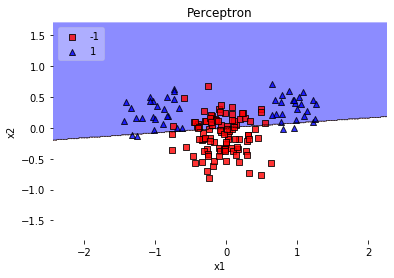

precision:
classA:0.9
classB:0.6


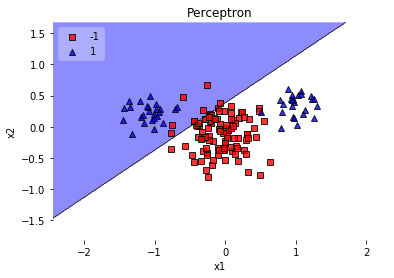

precision:
classA:0.5
classB:0.92


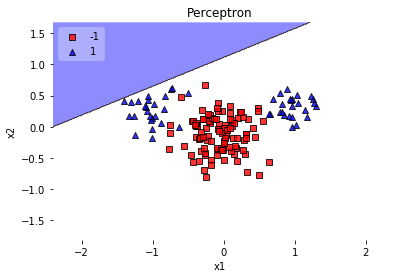

precision:
classA:0.0
classB:1.0


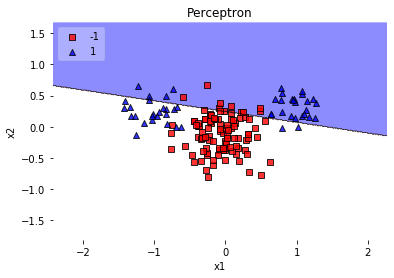

precision:
classA:0.56
classB:0.9


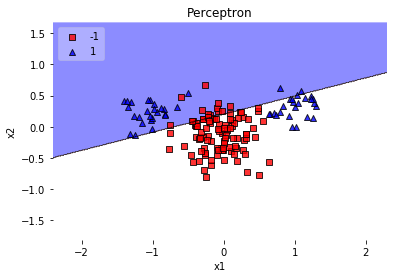

precision:
classA:0.56
classB:0.85


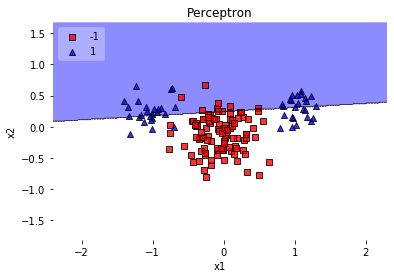

precision:
classA:0.64
classB:0.91


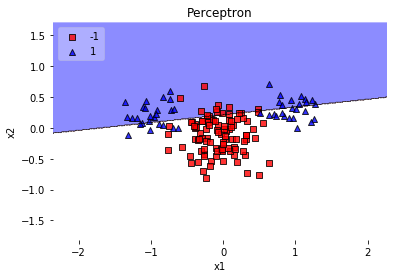

precision:
classA:0.58
classB:0.89


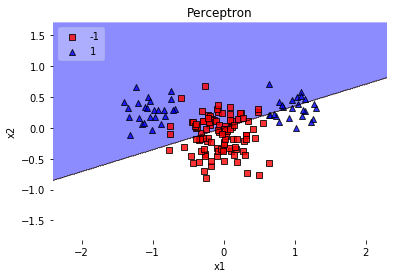

precision:
classA:0.7
classB:0.59


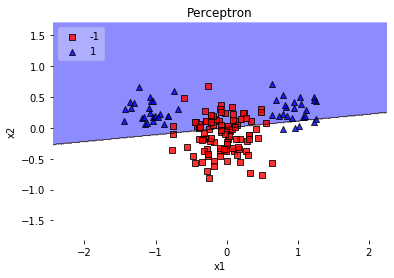

precision:
classA:0.92
classB:0.6


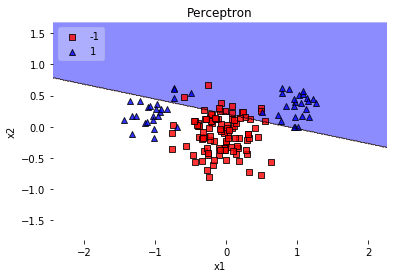

precision:
classA:0.58
classB:0.86


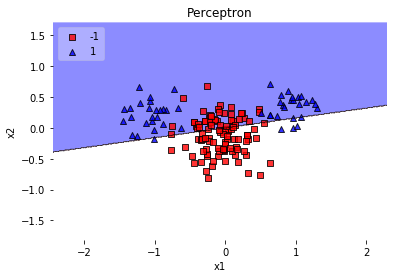

precision:
classA:0.9
classB:0.6


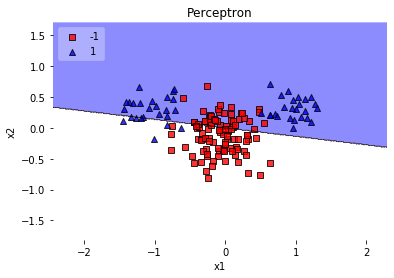

precision:
classA:0.86
classB:0.63


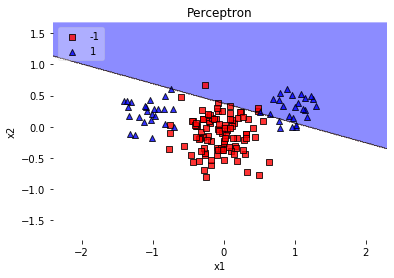

precision:
classA:0.4
classB:0.97


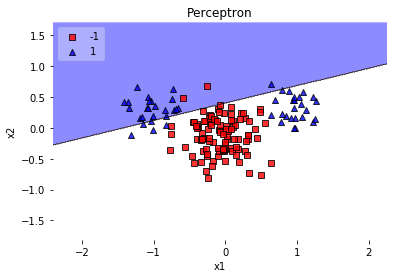

precision:
classA:0.44
classB:0.98


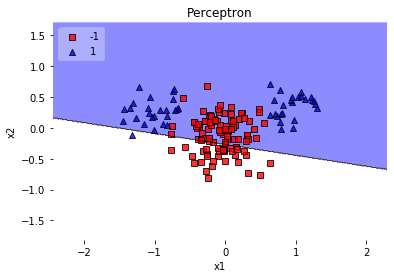

precision:
classA:0.98
classB:0.32


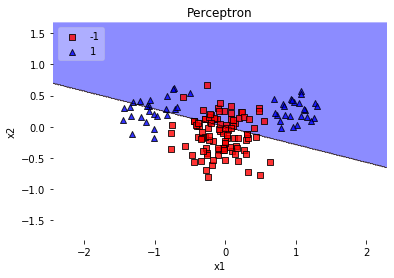

precision:
classA:0.74
classB:0.66


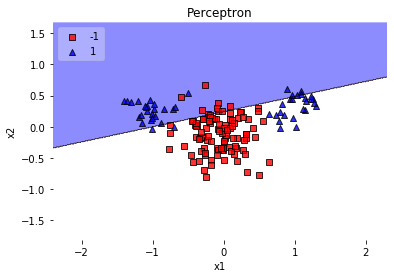

precision:
classA:0.56
classB:0.91


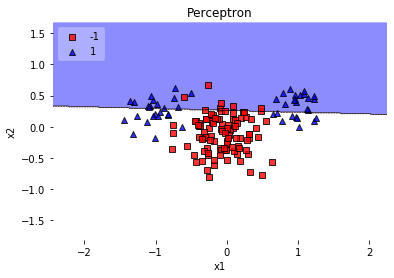

precision:
classA:0.58
classB:0.93


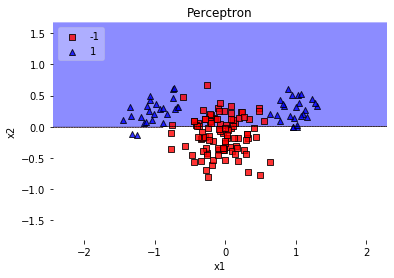

precision:
classA:0.9
classB:0.6


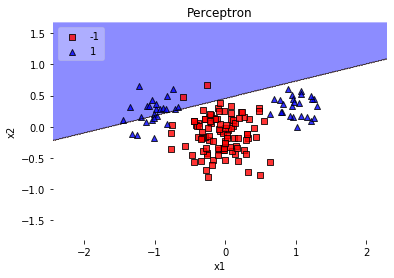

precision:
classA:0.34
classB:0.98


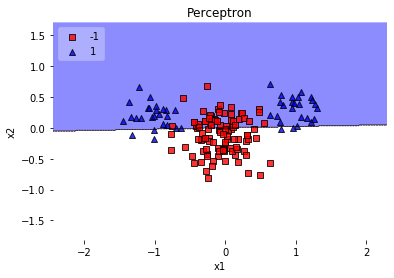

precision:
classA:0.9
classB:0.6


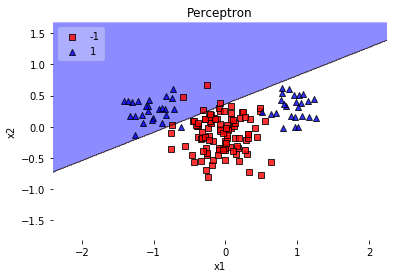

precision:
classA:0.48
classB:0.95


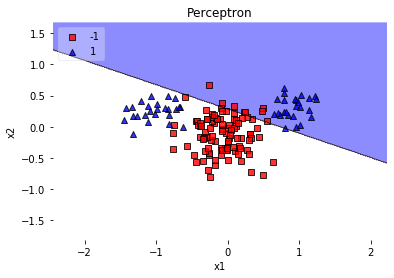

precision:
classA:0.5
classB:0.92


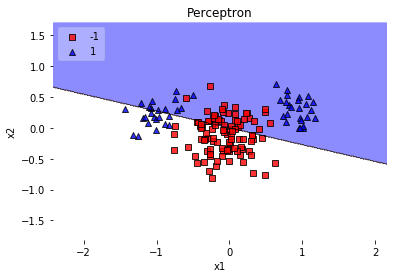

precision:
classA:0.72
classB:0.65


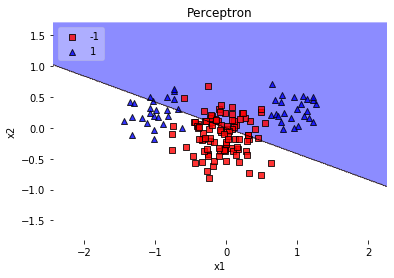

precision:
classA:0.64
classB:0.65


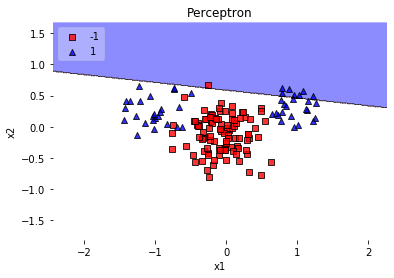

precision:
classA:0.14
classB:0.99


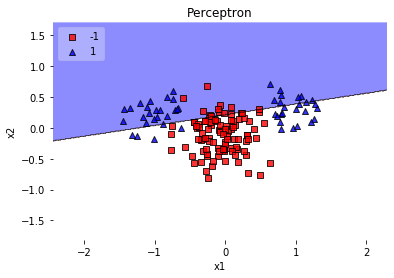

precision:
classA:0.58
classB:0.89


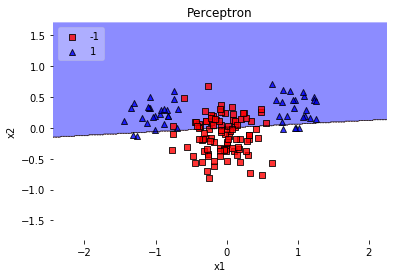

precision:
classA:0.88
classB:0.6


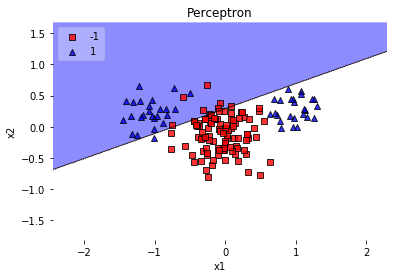

precision:
classA:0.48
classB:0.92


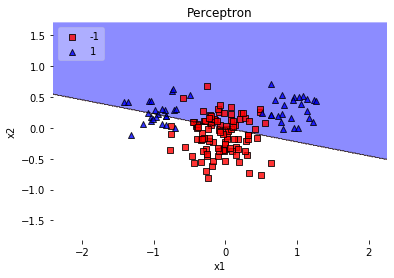

precision:
classA:0.82
classB:0.64


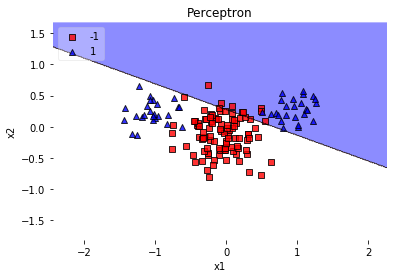

precision:
classA:0.5
classB:0.92


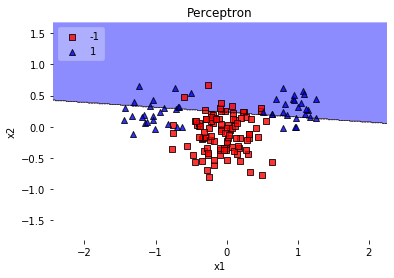

precision:
classA:0.6
classB:0.88


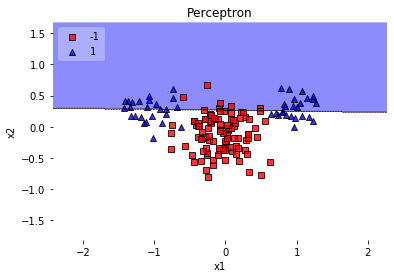

precision:
classA:0.56
classB:0.93


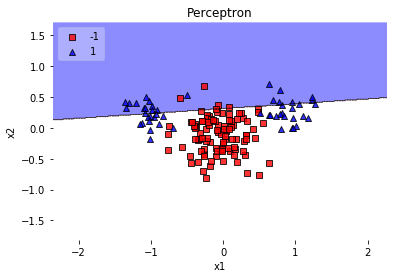

precision:
classA:0.4
classB:0.95


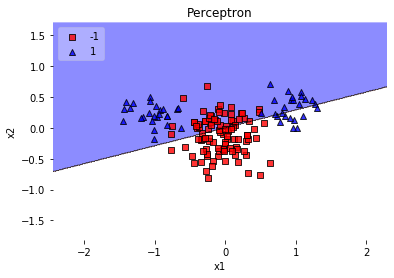

precision:
classA:0.82
classB:0.59


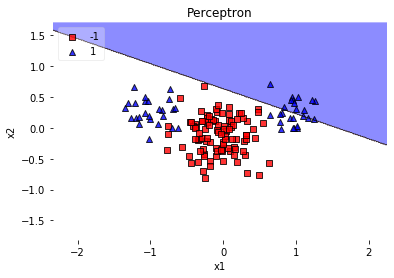

precision:
classA:0.26
classB:1.0


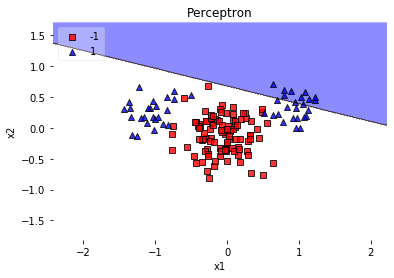

precision:
classA:0.22
classB:1.0


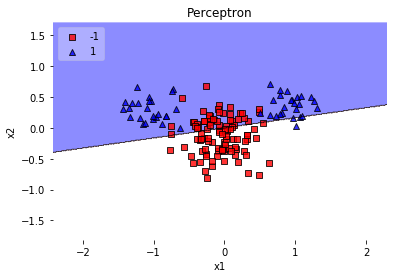

precision:
classA:0.94
classB:0.6


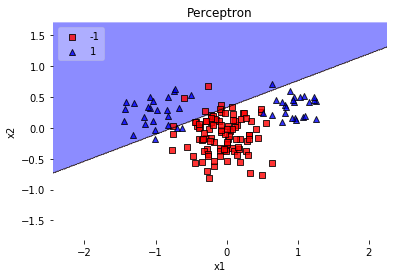

precision:
classA:0.46
classB:0.94


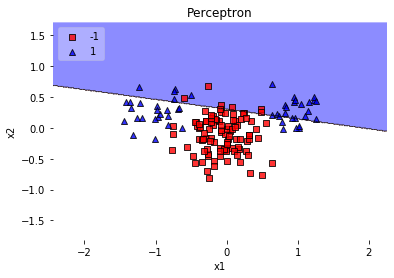

precision:
classA:0.5
classB:0.94


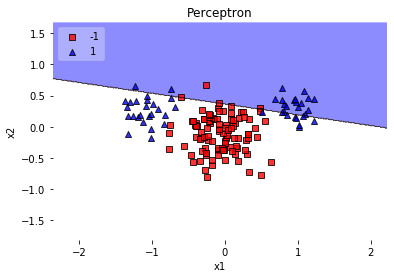

precision:
classA:0.38
classB:0.97


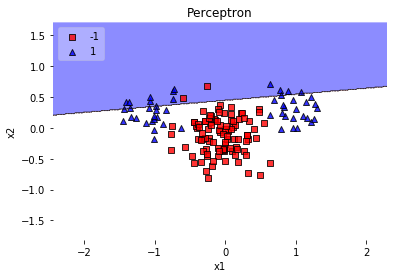

precision:
classA:0.28
classB:0.98


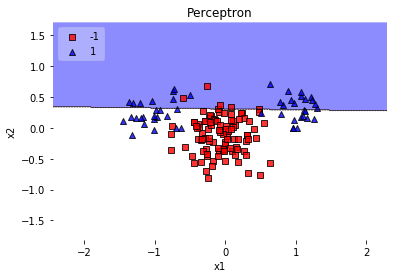

precision:
classA:0.42
classB:0.95


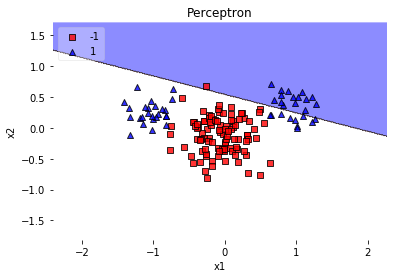

precision:
classA:0.3
classB:0.99


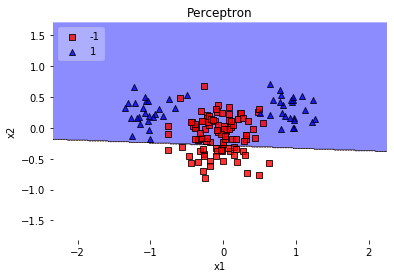

precision:
classA:1.0
classB:0.32


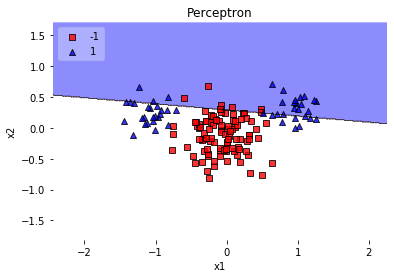

precision:
classA:0.38
classB:0.93


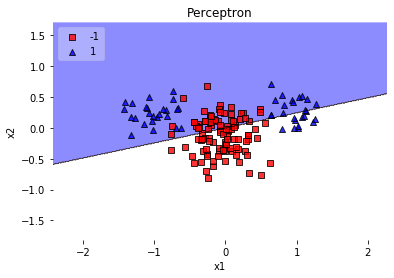

precision:
classA:0.78
classB:0.6


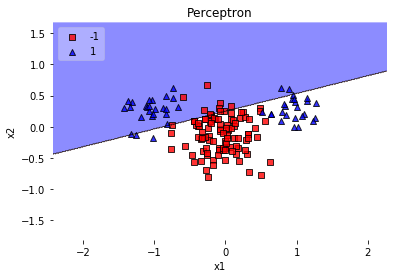

precision:
classA:0.5
classB:0.91


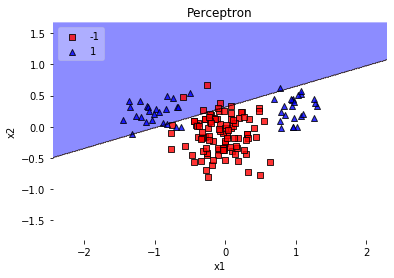

precision:
classA:0.48
classB:0.94


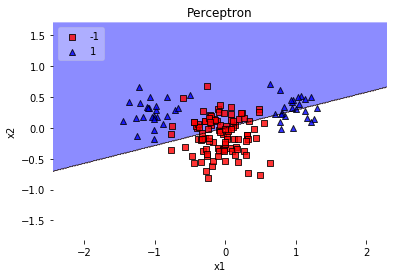

precision:
classA:0.82
classB:0.59


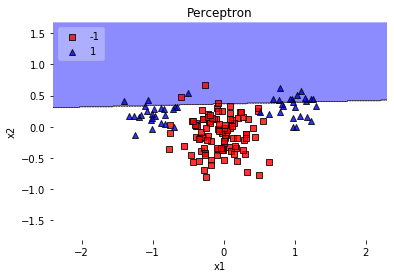

precision:
classA:0.3
classB:0.97


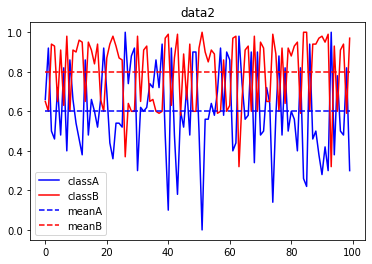

In [25]:
print('random 50% from classA')
resultsA = []
resultsB = []
for ri in range(iters):
    A1=classA1
    np.random.shuffle(A1)
    A1 = A1[0:25]
    A2 = classA2
    np.random.shuffle(A2)
    A2= A2[0:25]
    A = np.concatenate((A1,A2))
    B=classB
    np.random.shuffle(B)
    inputs = np.concatenate((A, B))
    targets = np.concatenate((np.ones(A.shape[0],dtype=int), -np.ones(B.shape[0],dtype=int)))
    N = inputs.shape[0]  # Number of rows (samples)
    permute = list(range(N))
    np.random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]


    X = inputs
    y = targets
    ppn = Perceptron(epochs=20, eta=0.01)
    ppn.train(X, y)
    plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
    plt.title('Perceptron')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('imgs/unseen_data2_eta{}_iter{}.png'.format(str(eta),ri))
    plt.show()

    a = 0
    b = 0
    for x,t in zip(inputs,targets):
        if ppn.predict(x)==t:
            if t == 1:
                a=a+1
            if t ==-1:
                b=b+1
    print('precision:')
    print('classA:'+str(a/len(A)))
    print('classB:'+str(b/len(B)))
    resultsA.append(a/len(A))
    resultsB.append(b/len(B))
x = [i for i in range(iters)]
plt.plot(x,resultsA,'b-',label='classA')
plt.plot(x,resultsB,'r-',label='classB')
A_mean = [np.mean(resultsA)]*len(x)
B_mean = [np.mean(resultsB)]*len(x)
plt.plot(x,A_mean, label='meanA', linestyle='--',c='b')
plt.plot(x,B_mean, label='meanB', linestyle='--',c='r')
plt.legend()
plt.title('data2')
plt.savefig('imgs/data2_precision.png')
plt.show()

* random 50% from classB

random 50% from classB


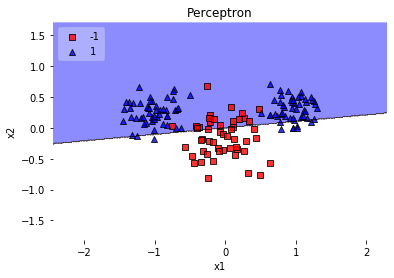

precision:
classA:0.92
classB:0.64


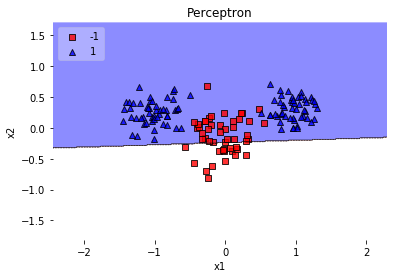

precision:
classA:1.0
classB:0.32


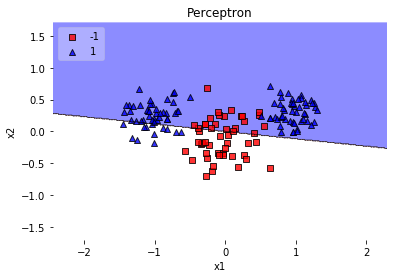

precision:
classA:0.88
classB:0.56


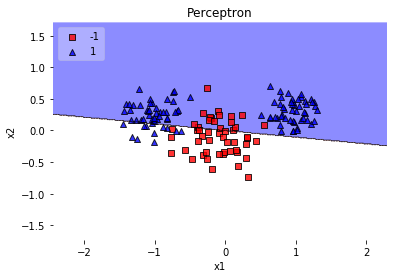

precision:
classA:0.89
classB:0.66


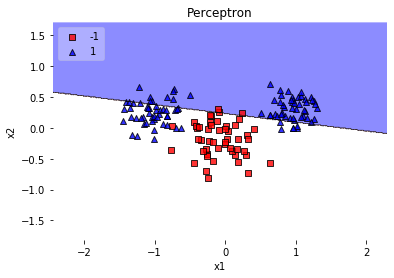

precision:
classA:0.54
classB:0.94


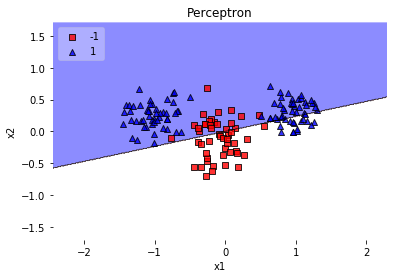

precision:
classA:0.85
classB:0.58


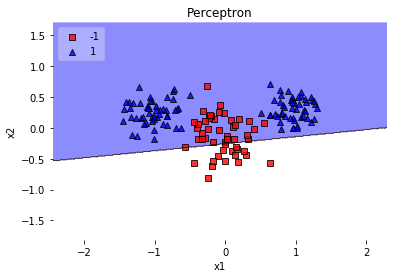

precision:
classA:1.0
classB:0.32


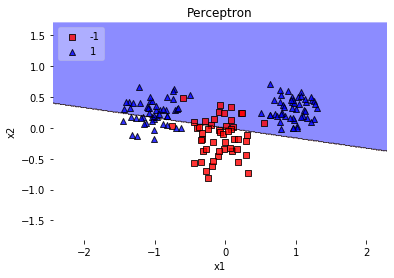

precision:
classA:0.83
classB:0.68


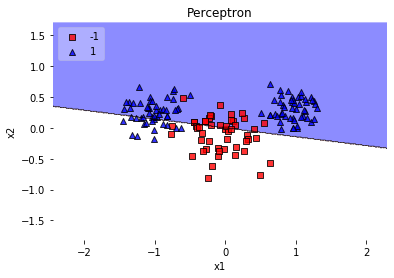

precision:
classA:0.85
classB:0.6


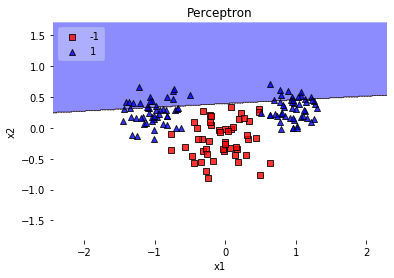

precision:
classA:0.29
classB:1.0


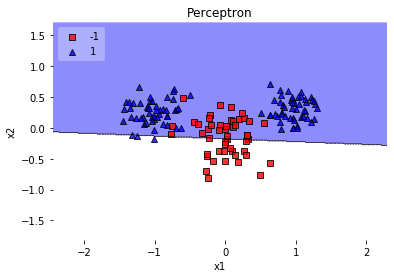

precision:
classA:0.98
classB:0.4


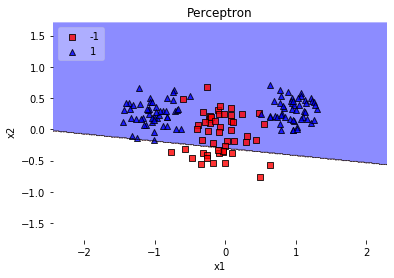

precision:
classA:1.0
classB:0.32


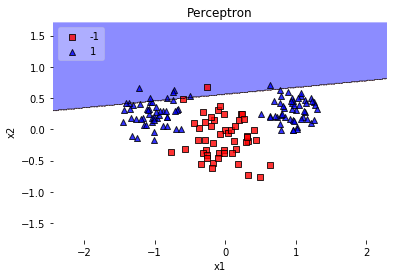

precision:
classA:0.09
classB:0.98


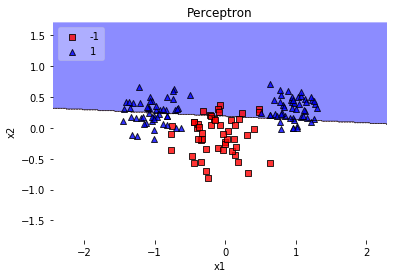

precision:
classA:0.68
classB:0.84


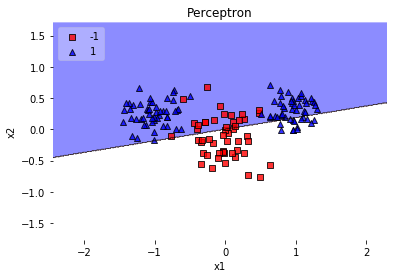

precision:
classA:0.86
classB:0.6


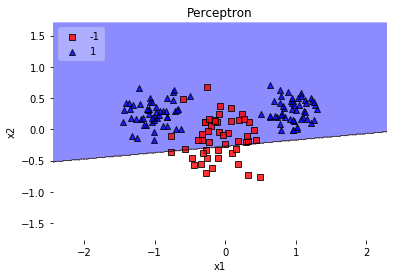

precision:
classA:1.0
classB:0.32


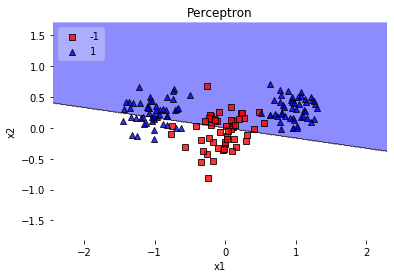

precision:
classA:0.83
classB:0.52


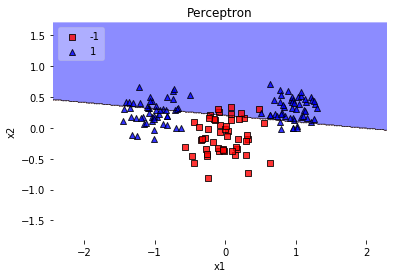

precision:
classA:0.64
classB:0.88


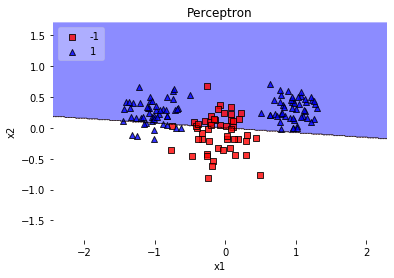

precision:
classA:0.89
classB:0.56


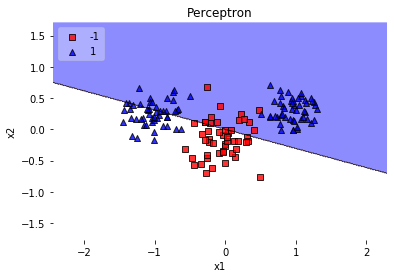

precision:
classA:0.67
classB:0.72


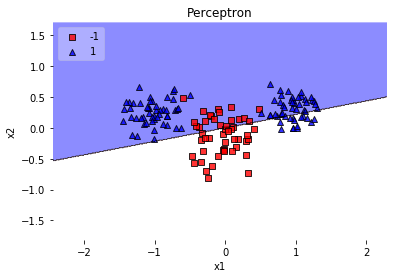

precision:
classA:0.86
classB:0.62


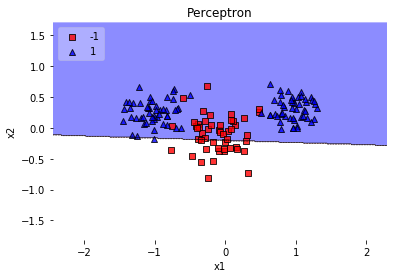

precision:
classA:0.99
classB:0.36


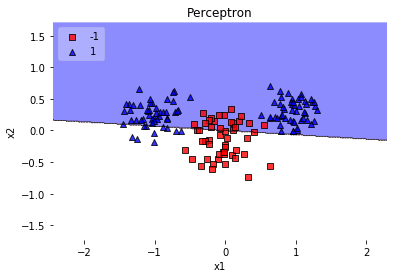

precision:
classA:0.9
classB:0.6


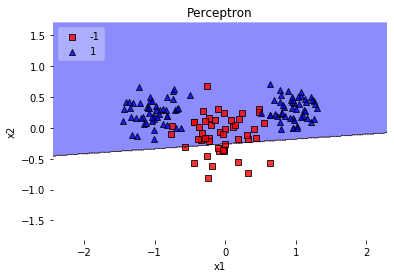

precision:
classA:1.0
classB:0.28


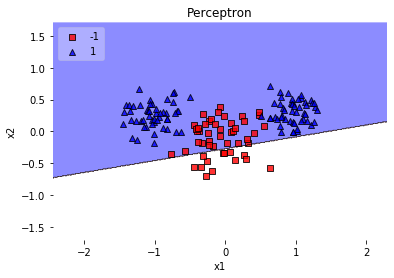

precision:
classA:1.0
classB:0.26


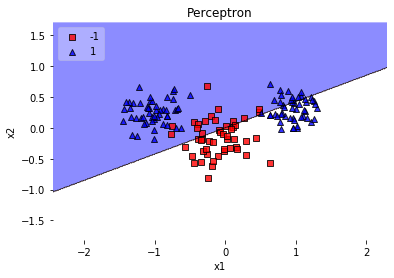

precision:
classA:0.65
classB:0.68


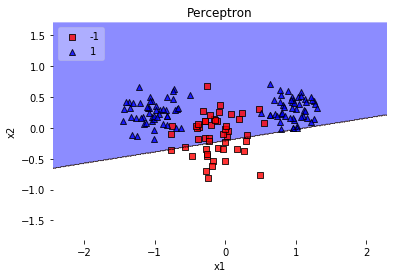

precision:
classA:1.0
classB:0.36


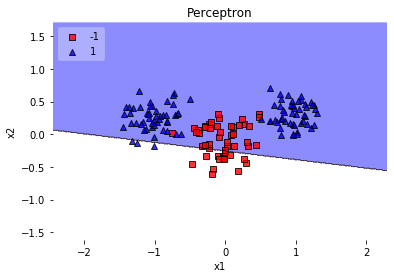

precision:
classA:0.97
classB:0.28


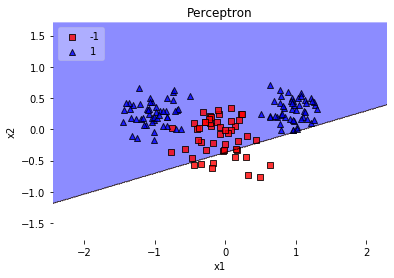

precision:
classA:1.0
classB:0.2


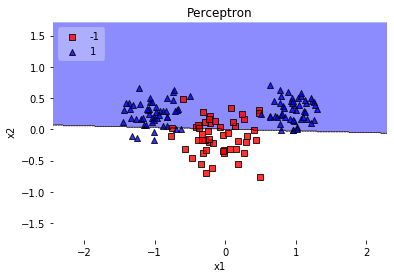

precision:
classA:0.94
classB:0.62


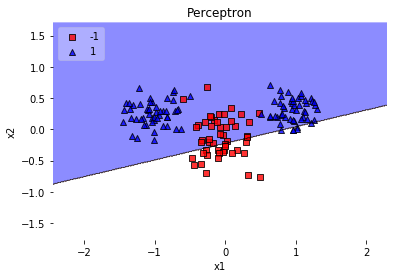

precision:
classA:0.95
classB:0.4


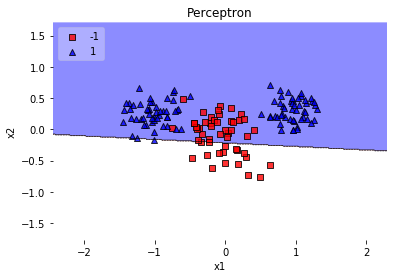

precision:
classA:0.99
classB:0.34


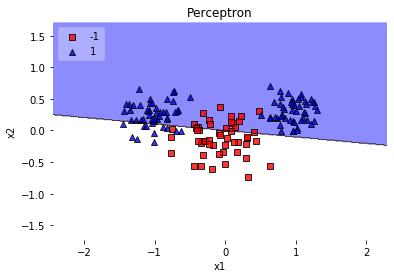

precision:
classA:0.89
classB:0.7


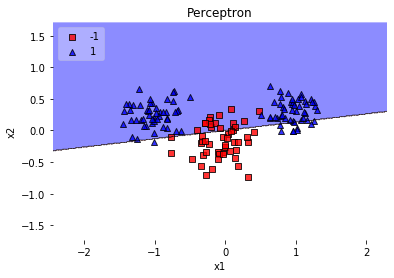

precision:
classA:0.91
classB:0.7


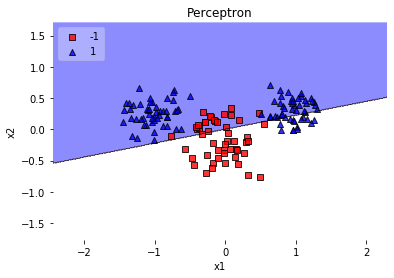

precision:
classA:0.86
classB:0.6


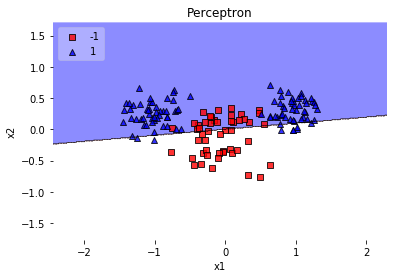

precision:
classA:0.92
classB:0.5


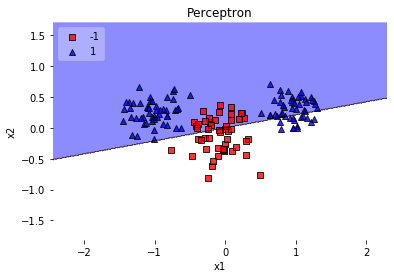

precision:
classA:0.86
classB:0.58


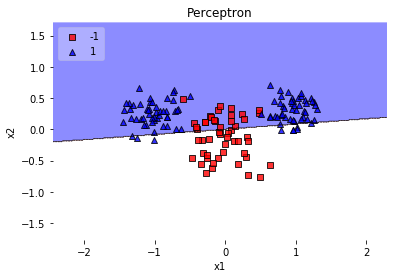

precision:
classA:0.92
classB:0.58


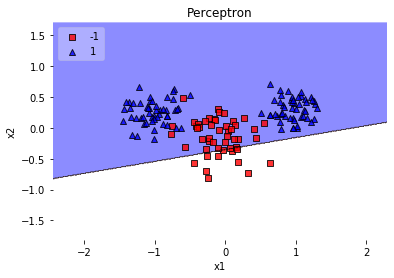

precision:
classA:1.0
classB:0.22


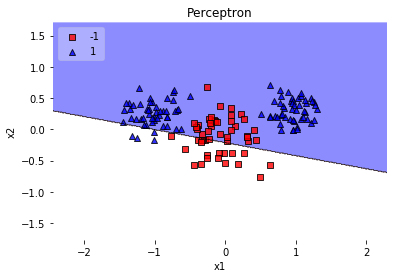

precision:
classA:0.96
classB:0.38


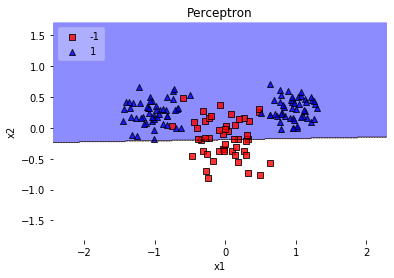

precision:
classA:1.0
classB:0.44


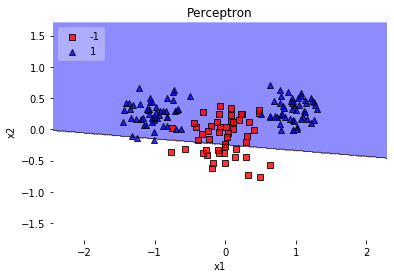

precision:
classA:0.98
classB:0.36


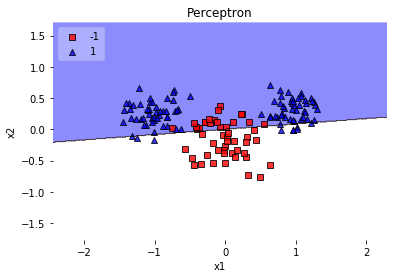

precision:
classA:0.92
classB:0.6


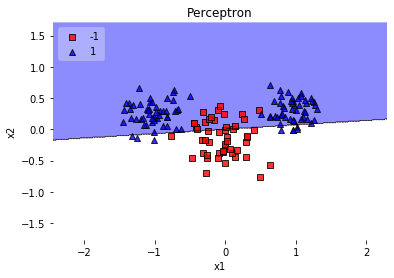

precision:
classA:0.92
classB:0.64


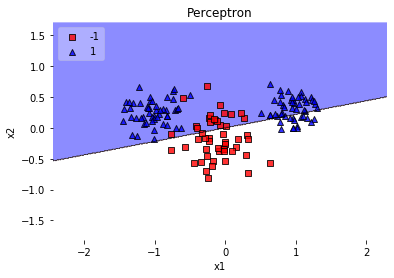

precision:
classA:0.86
classB:0.64


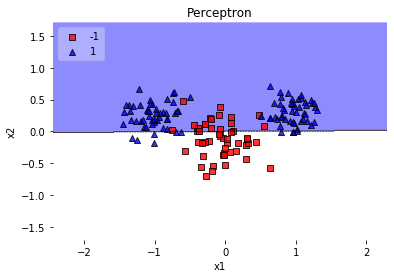

precision:
classA:0.92
classB:0.62


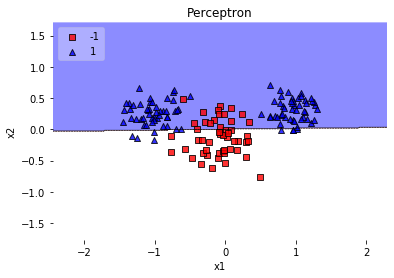

precision:
classA:0.92
classB:0.68


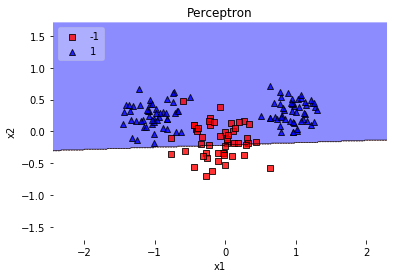

precision:
classA:1.0
classB:0.38


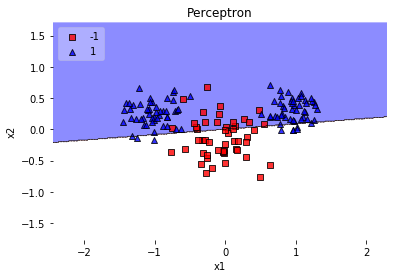

precision:
classA:0.92
classB:0.62


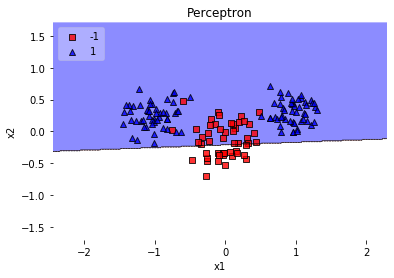

precision:
classA:1.0
classB:0.38


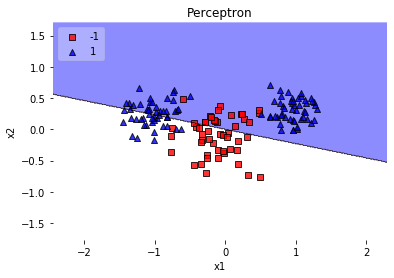

precision:
classA:0.78
classB:0.62


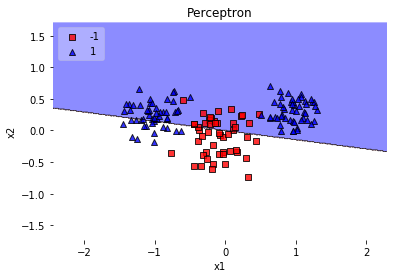

precision:
classA:0.85
classB:0.56


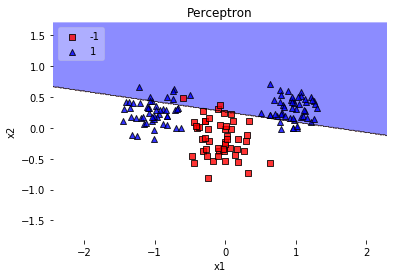

precision:
classA:0.52
classB:0.94


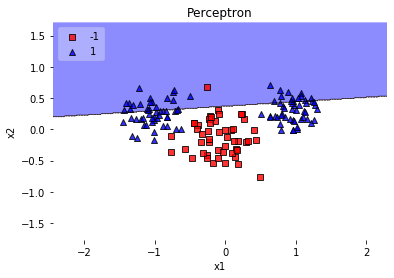

precision:
classA:0.33
classB:0.98


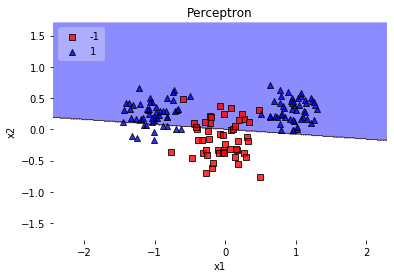

precision:
classA:0.89
classB:0.66


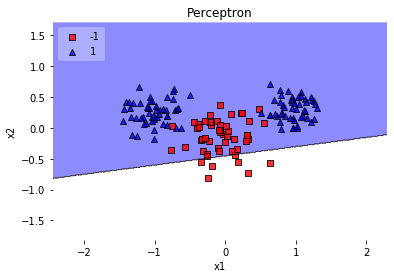

precision:
classA:1.0
classB:0.14


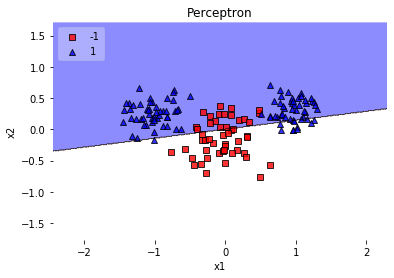

precision:
classA:0.89
classB:0.64


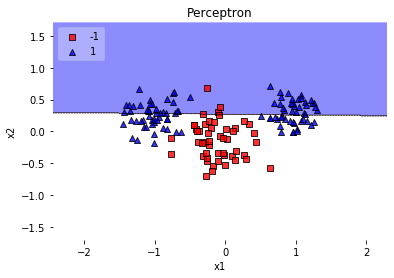

precision:
classA:0.54
classB:0.94


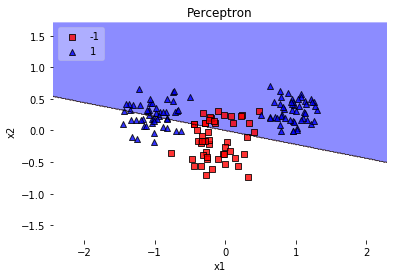

precision:
classA:0.79
classB:0.64


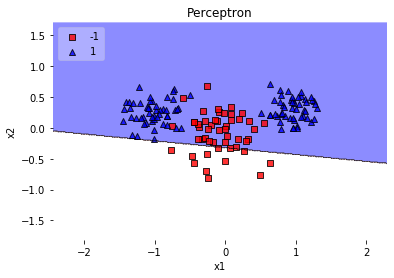

precision:
classA:1.0
classB:0.22


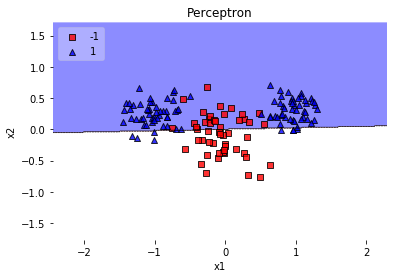

precision:
classA:0.92
classB:0.54


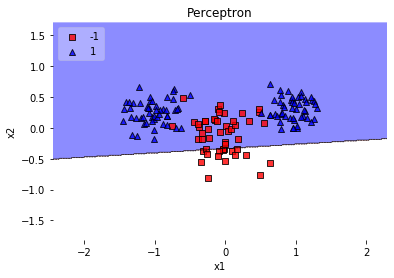

precision:
classA:1.0
classB:0.32


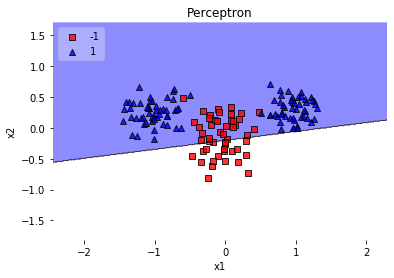

precision:
classA:1.0
classB:0.38


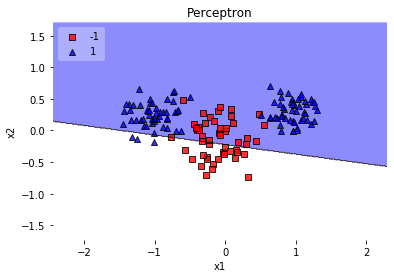

precision:
classA:0.97
classB:0.42


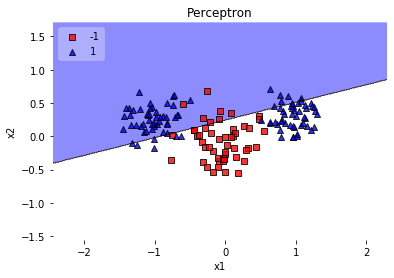

precision:
classA:0.52
classB:0.86


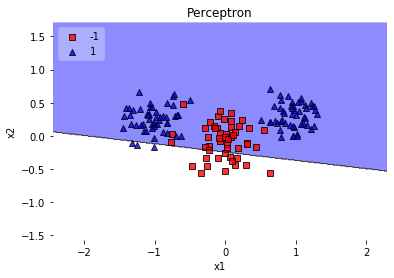

precision:
classA:0.97
classB:0.26


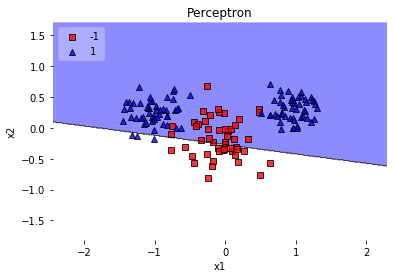

precision:
classA:0.97
classB:0.42


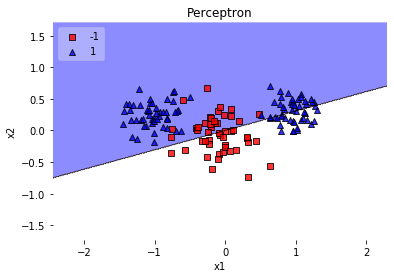

precision:
classA:0.78
classB:0.54


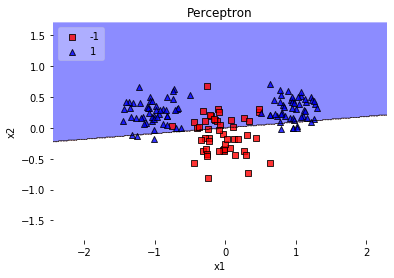

precision:
classA:0.92
classB:0.58


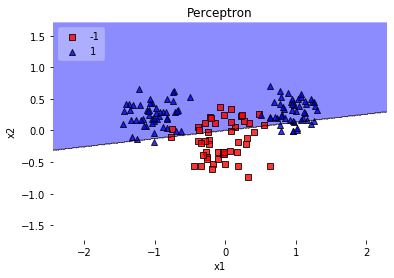

precision:
classA:0.91
classB:0.62


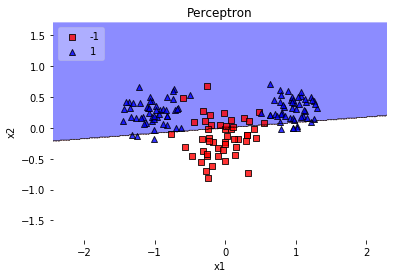

precision:
classA:0.92
classB:0.68


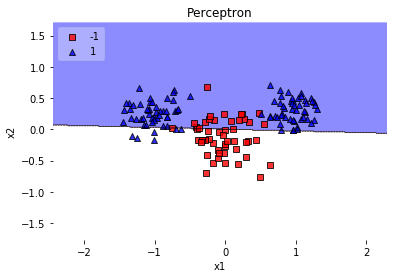

precision:
classA:0.94
classB:0.62


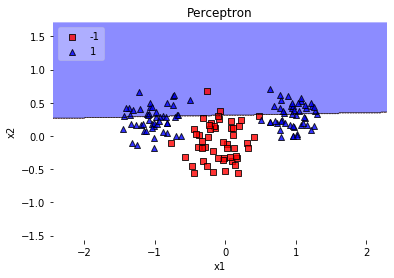

precision:
classA:0.45
classB:0.96


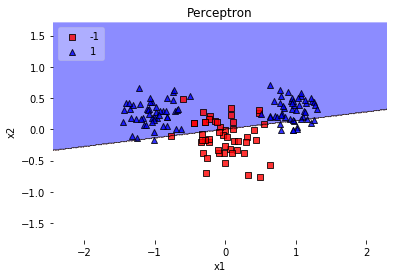

precision:
classA:0.9
classB:0.64


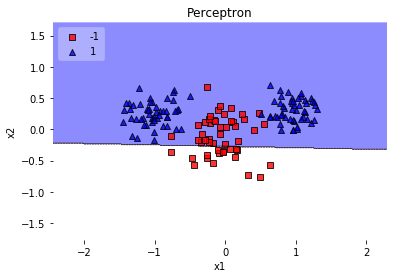

precision:
classA:1.0
classB:0.34


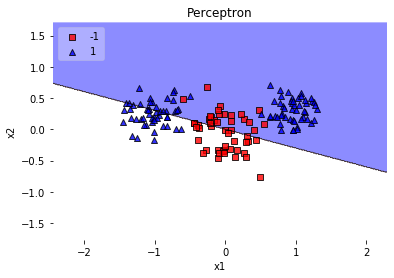

precision:
classA:0.7
classB:0.58


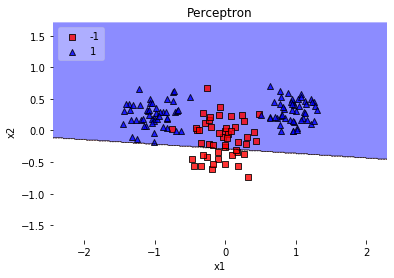

precision:
classA:1.0
classB:0.32


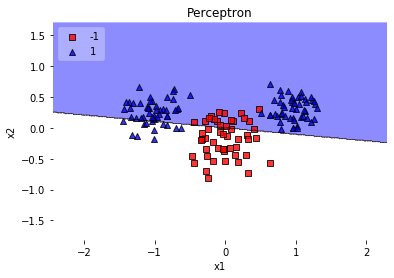

precision:
classA:0.89
classB:0.66


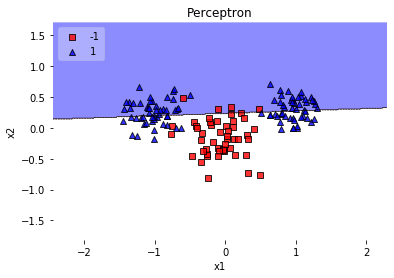

precision:
classA:0.56
classB:0.92


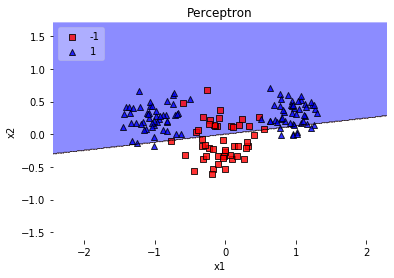

precision:
classA:0.91
classB:0.62


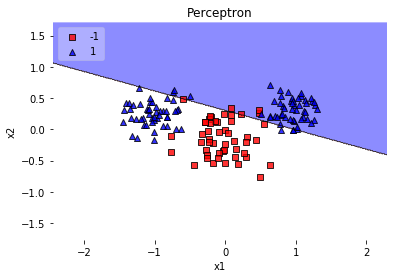

precision:
classA:0.5
classB:0.92


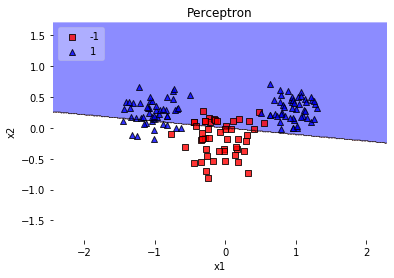

precision:
classA:0.89
classB:0.66


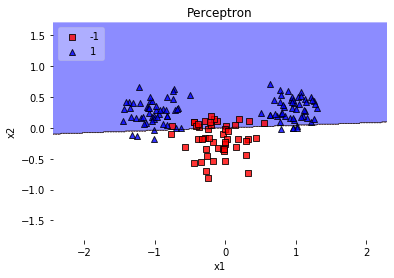

precision:
classA:0.92
classB:0.66


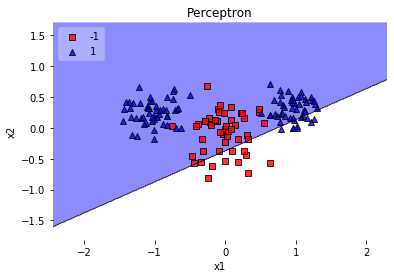

precision:
classA:0.92
classB:0.2


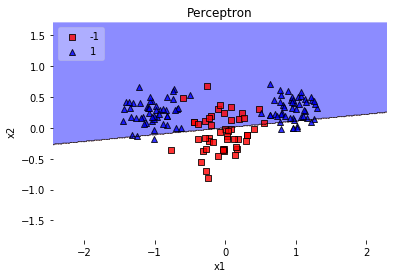

precision:
classA:0.93
classB:0.62


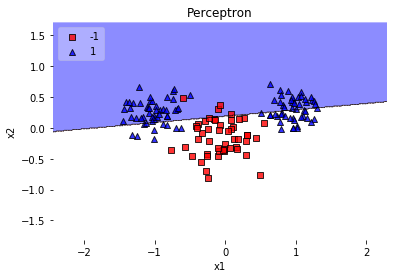

precision:
classA:0.66
classB:0.92


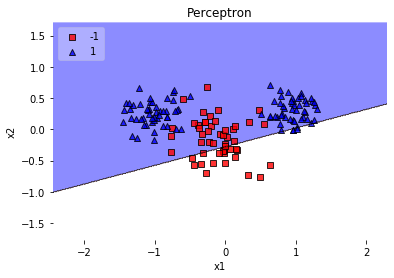

precision:
classA:0.97
classB:0.36


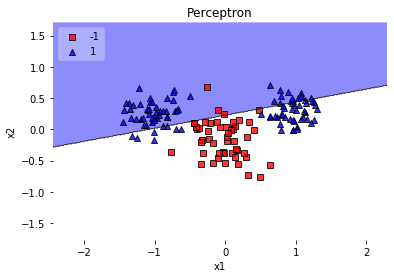

precision:
classA:0.57
classB:0.94


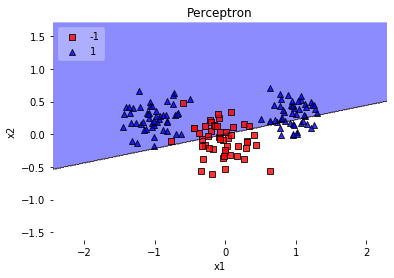

precision:
classA:0.86
classB:0.58


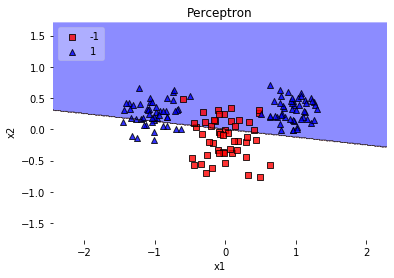

precision:
classA:0.88
classB:0.64


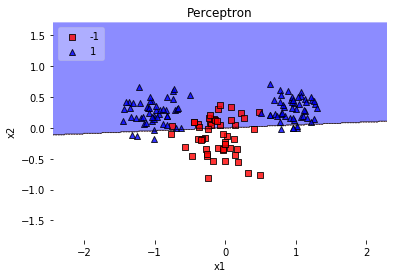

precision:
classA:0.92
classB:0.58


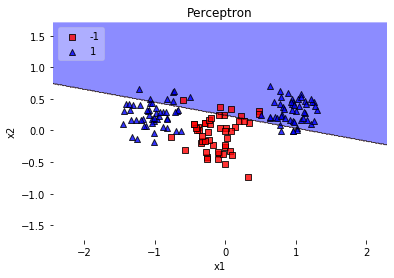

precision:
classA:0.52
classB:0.86


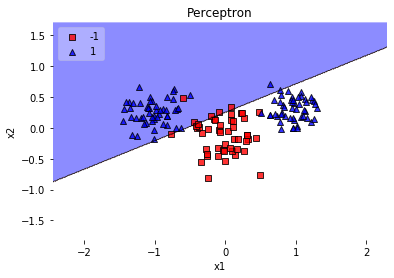

precision:
classA:0.52
classB:0.9


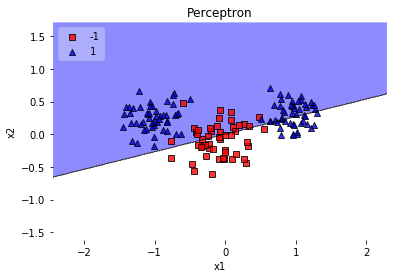

precision:
classA:0.81
classB:0.56


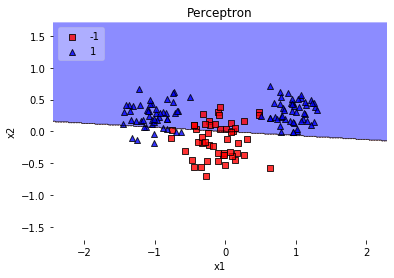

precision:
classA:0.92
classB:0.62


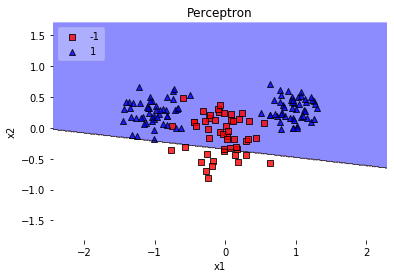

precision:
classA:1.0
classB:0.26


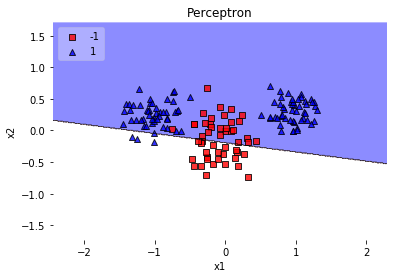

precision:
classA:0.97
classB:0.46


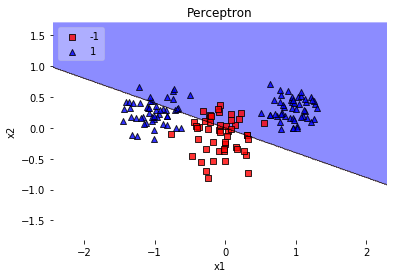

precision:
classA:0.62
classB:0.6


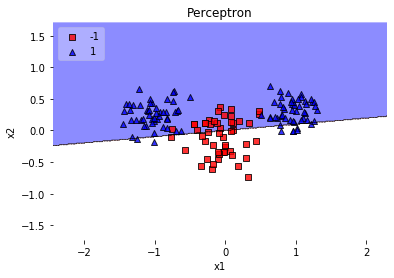

precision:
classA:0.92
classB:0.54


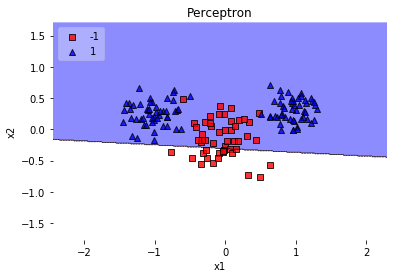

precision:
classA:1.0
classB:0.34


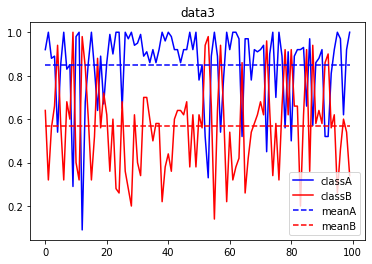

In [26]:
print('random 50% from classB')
resultsA = []
resultsB = []
for ri in range(iters):
    A = classA
    np.random.shuffle(A)
    B= classB
    np.random.shuffle(B)
    B=B[0:50]
    inputs = np.concatenate((A, B))
    targets = np.concatenate((np.ones(A.shape[0],dtype=int), -np.ones(B.shape[0],dtype=int)))
    N = inputs.shape[0]  # Number of rows (samples)
    permute = list(range(N))
    np.random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]


    X = inputs
    y = targets
    ppn = Perceptron(epochs=20, eta=0.01)
    ppn.train(X, y)
    plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
    plt.title('Perceptron')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('imgs/unseen_data3_eta{}_iter{}.png'.format(str(eta),ri))
    plt.show()

    a = 0
    b = 0
    for x,t in zip(inputs,targets):
        if ppn.predict(x)==t:
            if t == 1:
                a=a+1
            if t ==-1:
                b=b+1
    print('precision:')
    print('classA:'+str(a/len(A)))
    print('classB:'+str(b/len(B)))
    resultsA.append(a/len(A))
    resultsB.append(b/len(B))
x = [i for i in range(iters)]
plt.plot(x,resultsA,'b-',label='classA')
plt.plot(x,resultsB,'r-',label='classB')
A_mean = [np.mean(resultsA)]*len(x)
B_mean = [np.mean(resultsB)]*len(x)
plt.plot(x,A_mean, label='meanA', linestyle='--',c='b')
plt.plot(x,B_mean, label='meanB', linestyle='--',c='r')
plt.legend()
plt.title('data3')
plt.savefig('imgs/data3_precision.png')
plt.show()

* 20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0


20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0


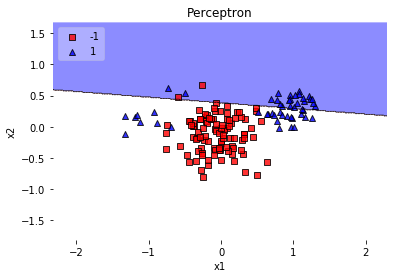

precision:
classA:0.48
classB:0.98


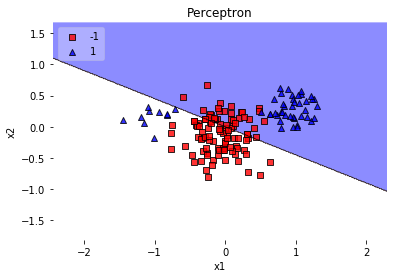

precision:
classA:0.8
classB:0.65


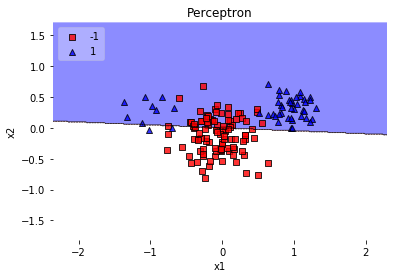

precision:
classA:0.96
classB:0.62


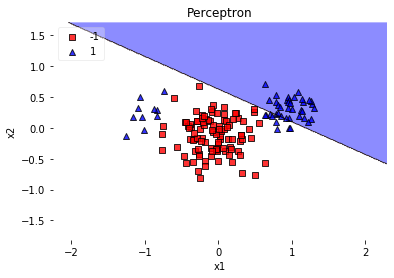

precision:
classA:0.64
classB:1.0


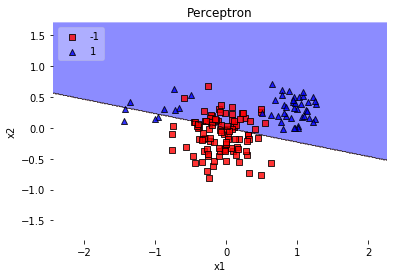

precision:
classA:0.92
classB:0.64


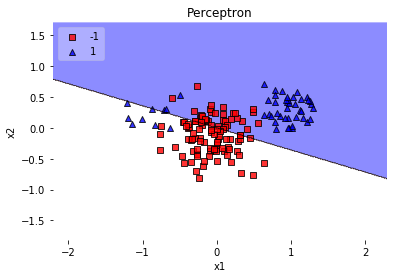

precision:
classA:0.86
classB:0.65


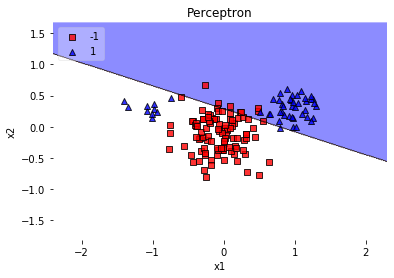

precision:
classA:0.78
classB:0.92


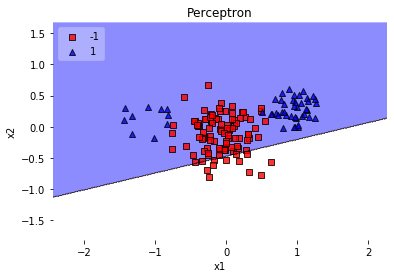

precision:
classA:1.0
classB:0.11


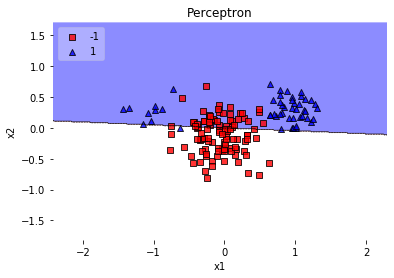

precision:
classA:0.98
classB:0.62


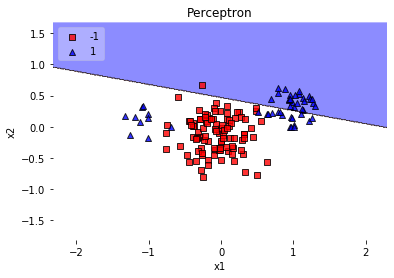

precision:
classA:0.48
classB:0.99


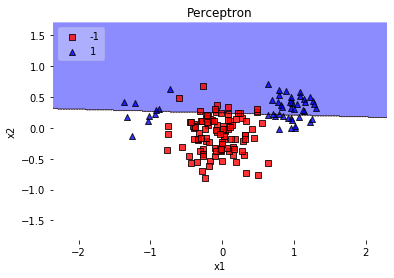

precision:
classA:0.64
classB:0.88


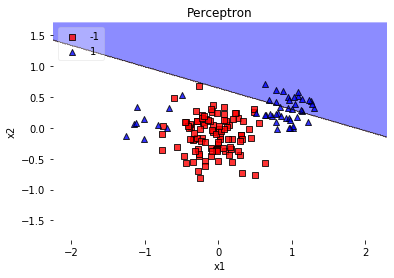

precision:
classA:0.4
classB:1.0


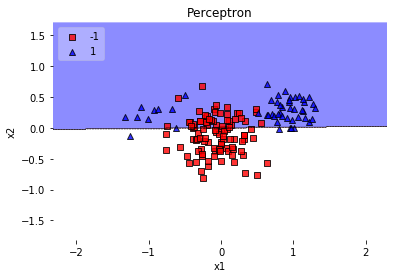

precision:
classA:0.9
classB:0.6


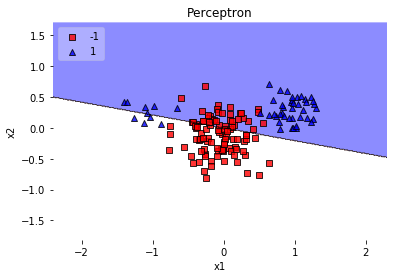

precision:
classA:0.92
classB:0.63


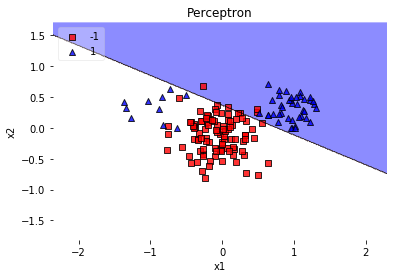

precision:
classA:0.8
classB:0.96


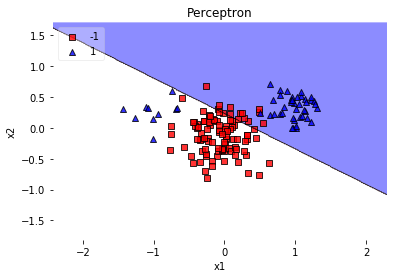

precision:
classA:0.8
classB:0.86


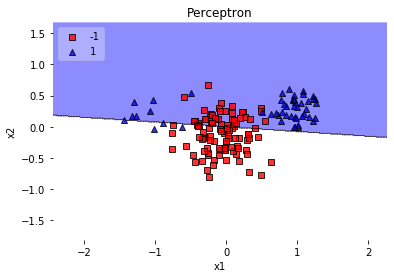

precision:
classA:0.94
classB:0.62


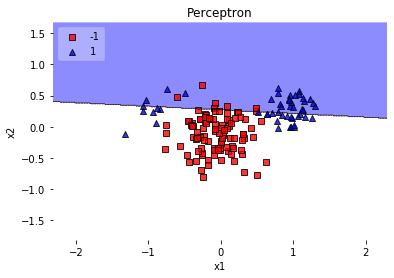

precision:
classA:0.5
classB:0.93


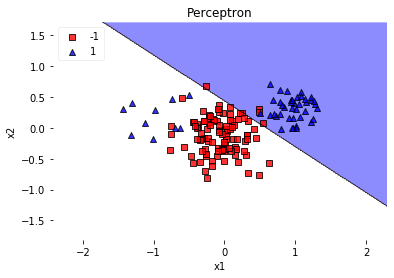

precision:
classA:0.8
classB:0.96


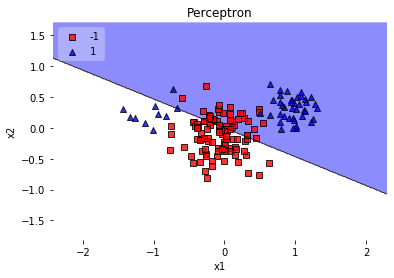

precision:
classA:0.84
classB:0.66


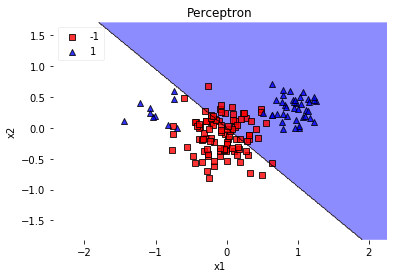

precision:
classA:0.8
classB:0.69


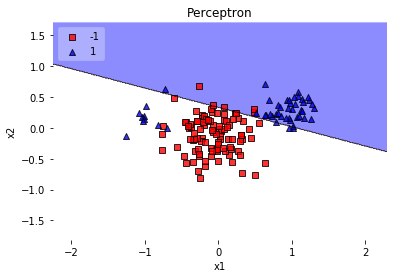

precision:
classA:0.78
classB:0.95


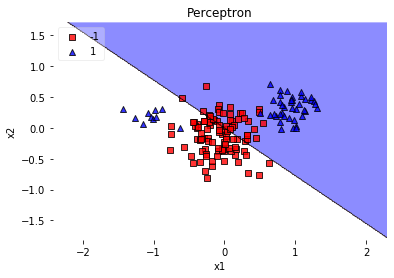

precision:
classA:0.8
classB:0.66


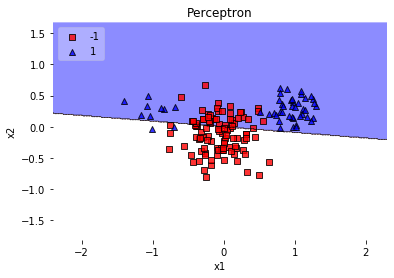

precision:
classA:0.96
classB:0.63


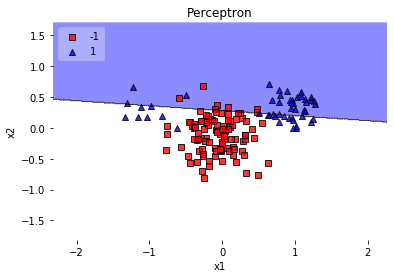

precision:
classA:0.6
classB:0.93


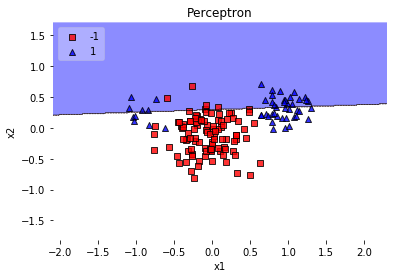

precision:
classA:0.48
classB:0.95


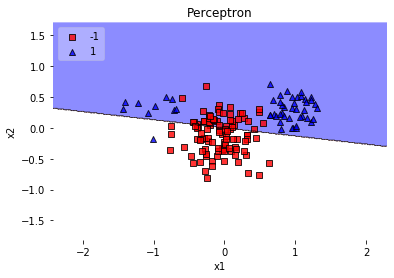

precision:
classA:0.98
classB:0.63


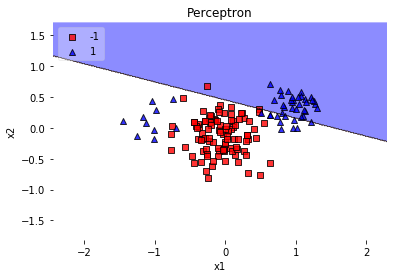

precision:
classA:0.6
classB:0.99


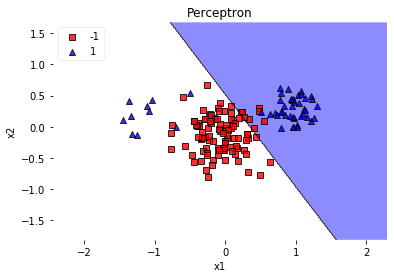

precision:
classA:0.8
classB:0.92


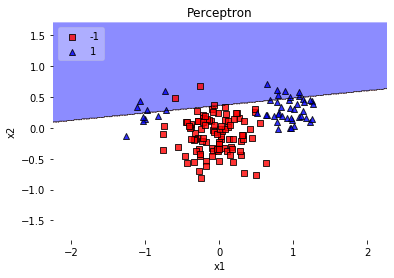

precision:
classA:0.26
classB:0.97


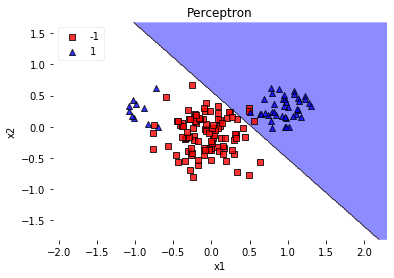

precision:
classA:0.8
classB:0.97


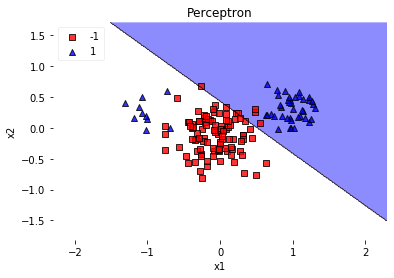

precision:
classA:0.8
classB:0.95


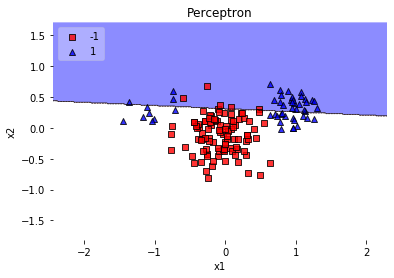

precision:
classA:0.54
classB:0.95


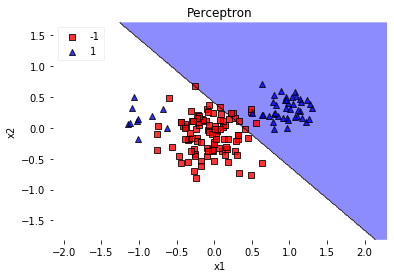

precision:
classA:0.8
classB:0.91


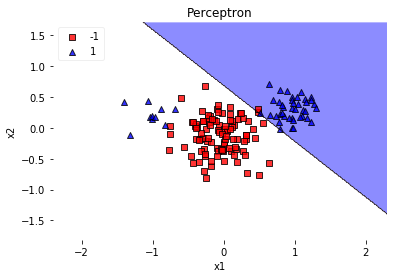

precision:
classA:0.8
classB:0.98


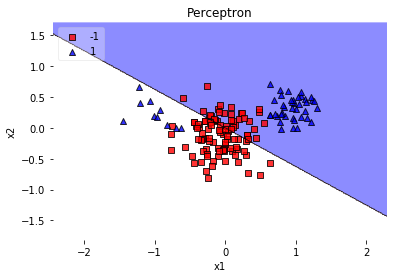

precision:
classA:0.8
classB:0.66


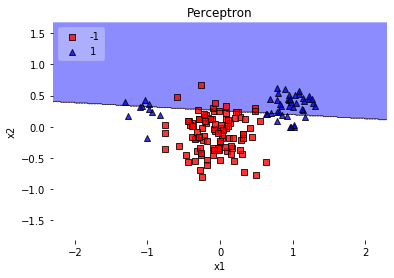

precision:
classA:0.66
classB:0.93


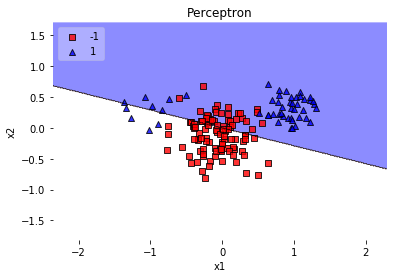

precision:
classA:0.92
classB:0.66


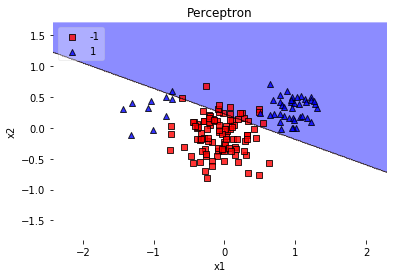

precision:
classA:0.82
classB:0.85


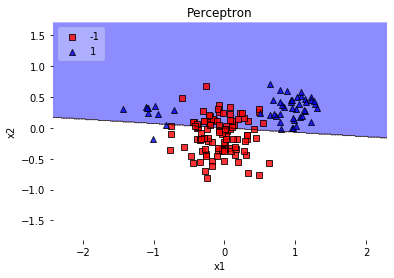

precision:
classA:0.96
classB:0.62


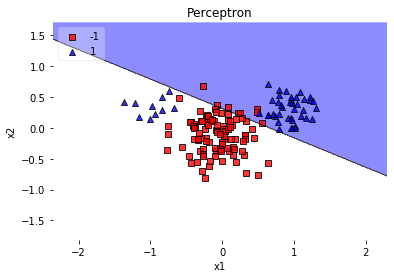

precision:
classA:0.8
classB:0.92


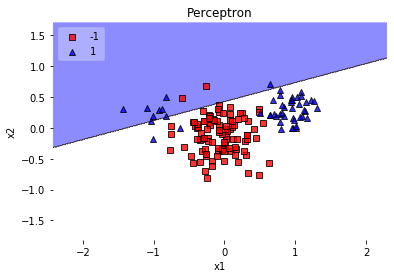

precision:
classA:0.18
classB:0.98


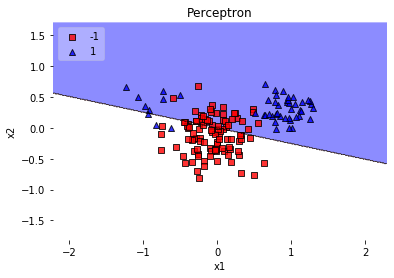

precision:
classA:0.94
classB:0.65


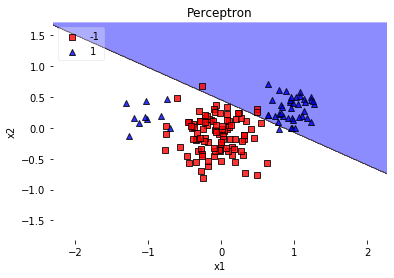

precision:
classA:0.78
classB:0.97


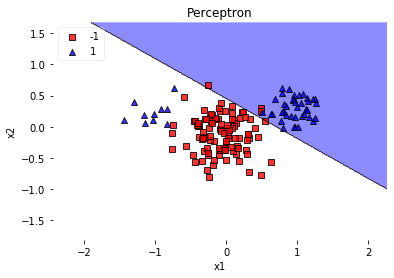

precision:
classA:0.8
classB:0.97


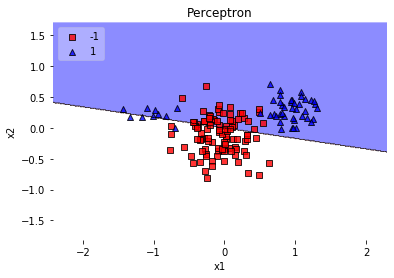

precision:
classA:0.94
classB:0.63


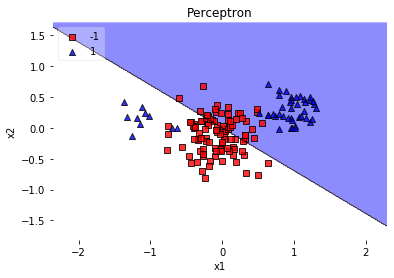

precision:
classA:0.8
classB:0.66


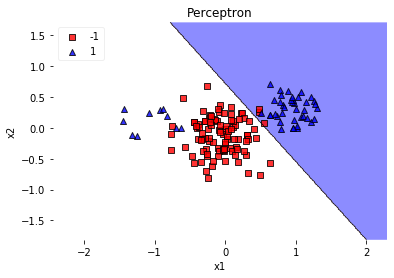

precision:
classA:0.8
classB:0.97


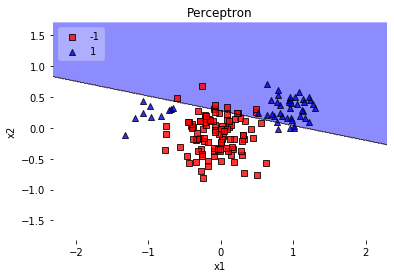

precision:
classA:0.72
classB:0.91


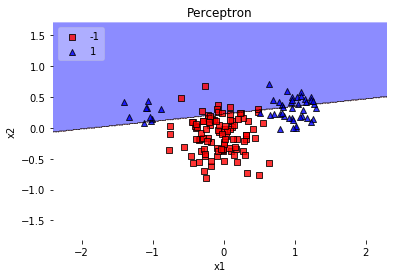

precision:
classA:0.56
classB:0.9


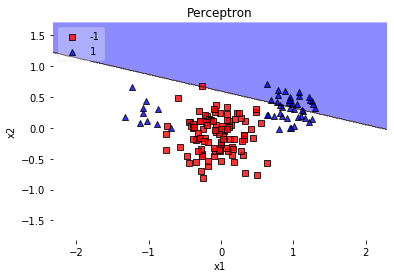

precision:
classA:0.4
classB:0.99


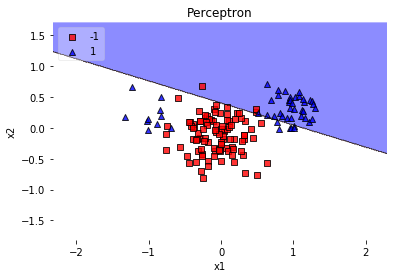

precision:
classA:0.68
classB:0.97


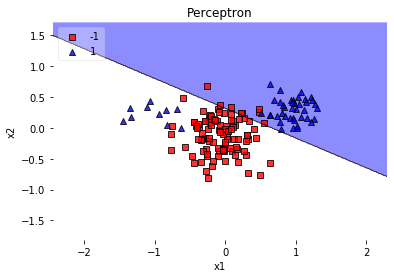

precision:
classA:0.8
classB:0.92


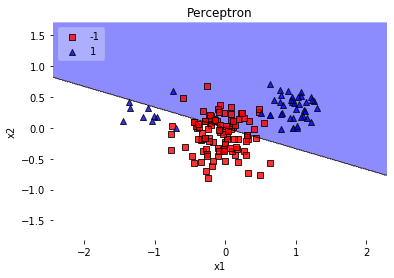

precision:
classA:0.82
classB:0.66


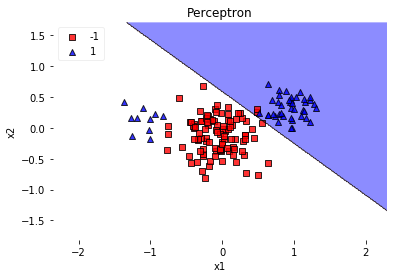

precision:
classA:0.8
classB:0.98


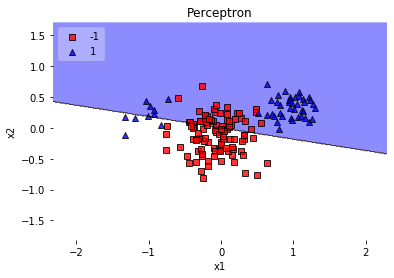

precision:
classA:0.92
classB:0.63


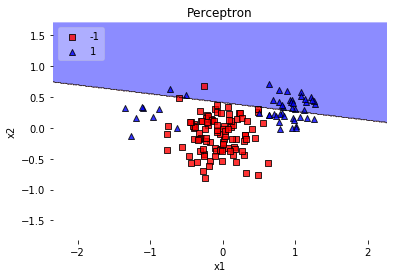

precision:
classA:0.48
classB:0.99


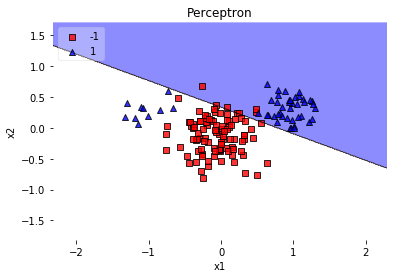

precision:
classA:0.8
classB:0.94


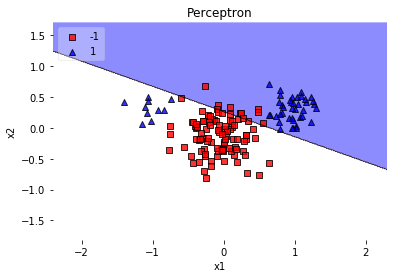

precision:
classA:0.8
classB:0.9


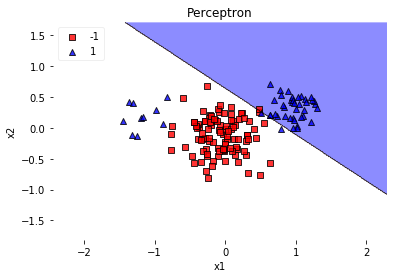

precision:
classA:0.76
classB:0.99


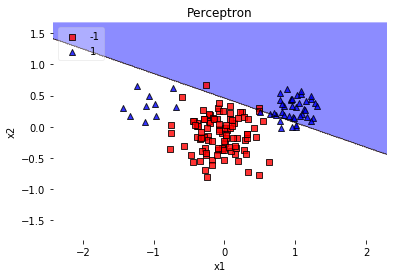

precision:
classA:0.68
classB:0.98


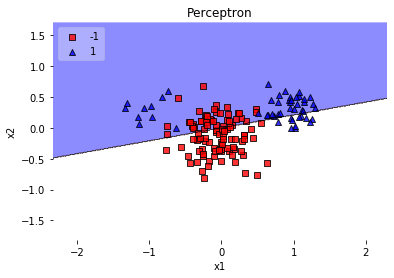

precision:
classA:0.78
classB:0.6


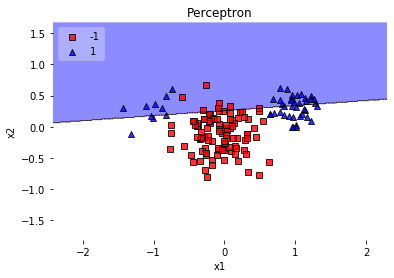

precision:
classA:0.54
classB:0.93


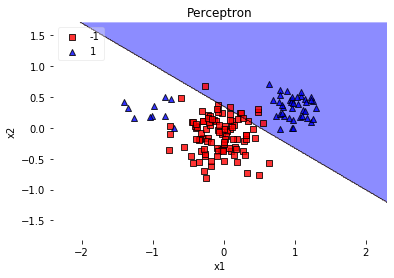

precision:
classA:0.8
classB:0.93


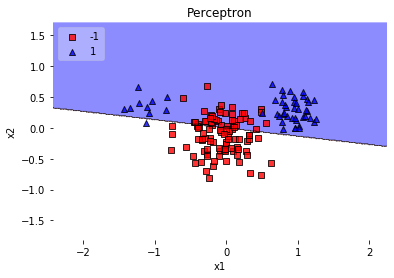

precision:
classA:0.98
classB:0.63


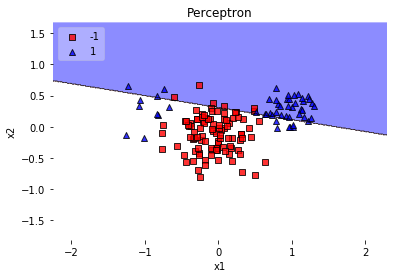

precision:
classA:0.74
classB:0.94


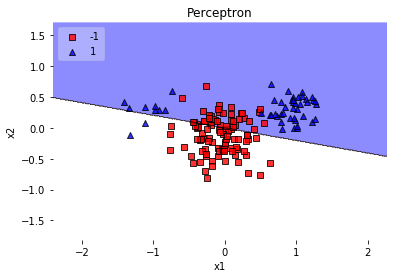

precision:
classA:0.96
classB:0.63


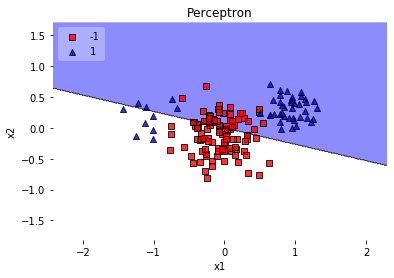

precision:
classA:0.88
classB:0.65


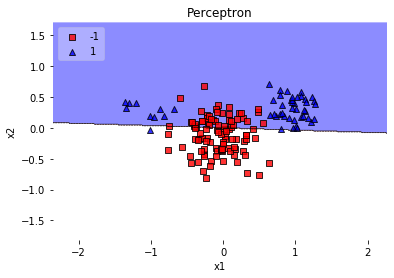

precision:
classA:0.98
classB:0.63


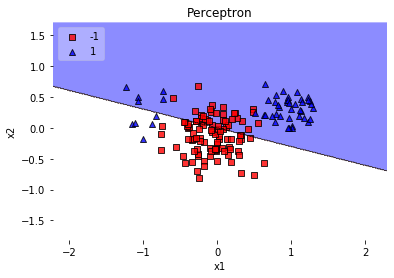

precision:
classA:0.9
classB:0.66


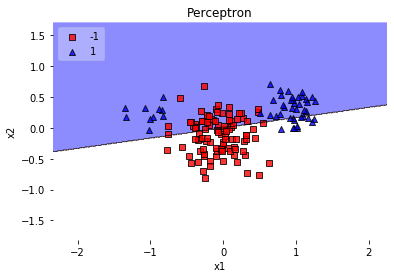

precision:
classA:0.78
classB:0.6


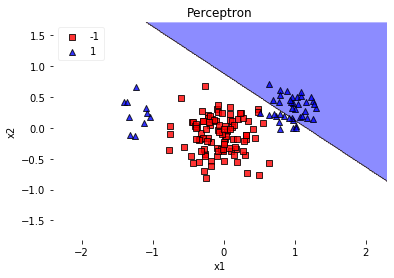

precision:
classA:0.54
classB:1.0


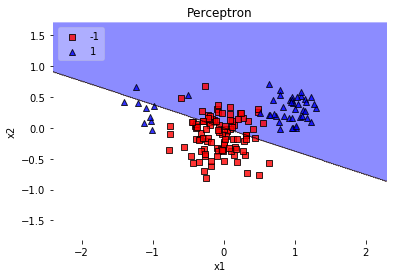

precision:
classA:0.84
classB:0.64


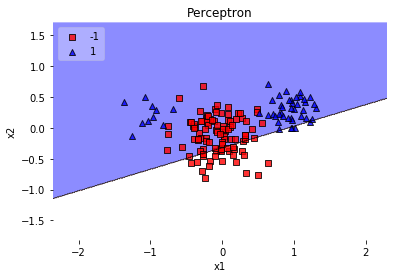

precision:
classA:0.92
classB:0.26


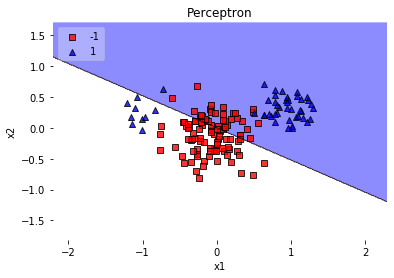

precision:
classA:0.82
classB:0.66


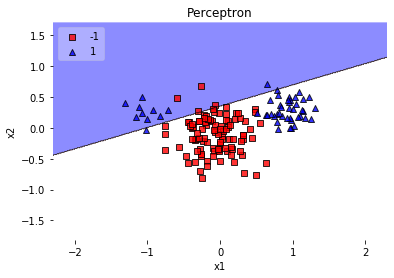

precision:
classA:0.2
classB:0.96


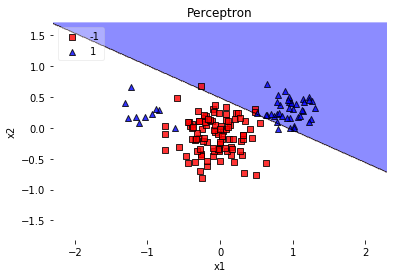

precision:
classA:0.78
classB:0.97


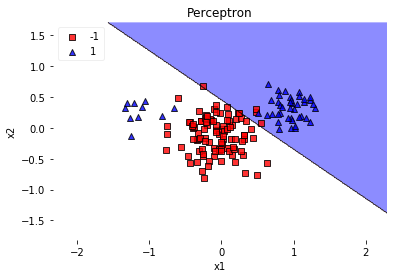

precision:
classA:0.8
classB:0.96


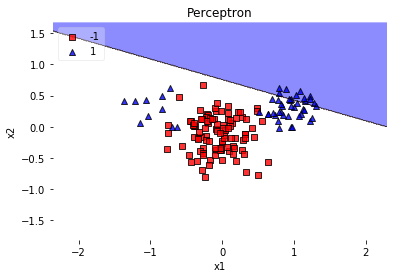

precision:
classA:0.26
classB:1.0


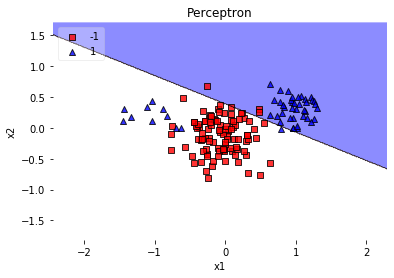

precision:
classA:0.78
classB:0.97


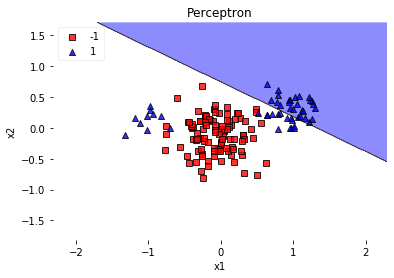

precision:
classA:0.52
classB:1.0


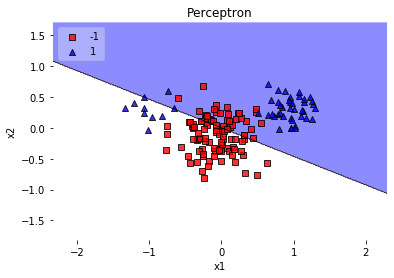

precision:
classA:0.86
classB:0.65


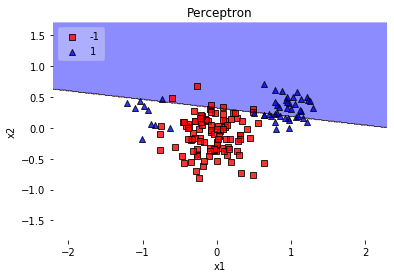

precision:
classA:0.54
classB:0.94


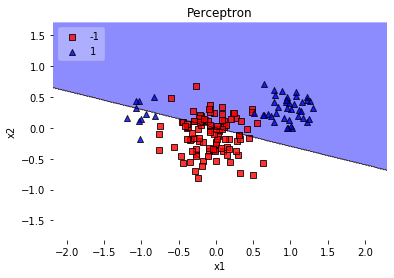

precision:
classA:0.88
classB:0.66


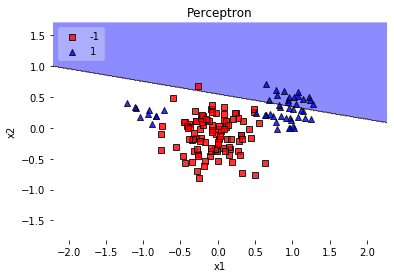

precision:
classA:0.32
classB:0.99


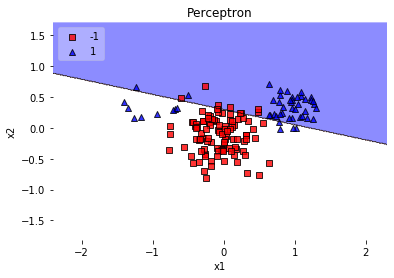

precision:
classA:0.76
classB:0.93


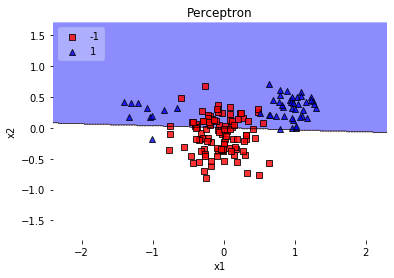

precision:
classA:0.98
classB:0.62


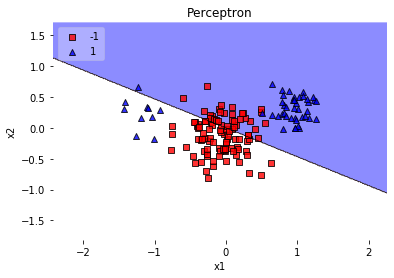

precision:
classA:0.82
classB:0.66


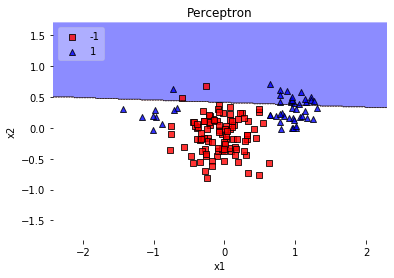

precision:
classA:0.36
classB:0.98


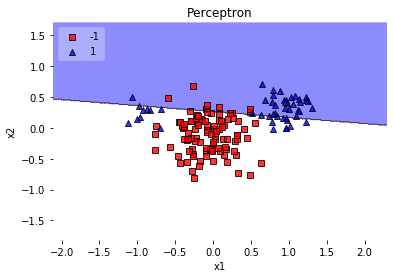

precision:
classA:0.62
classB:0.93


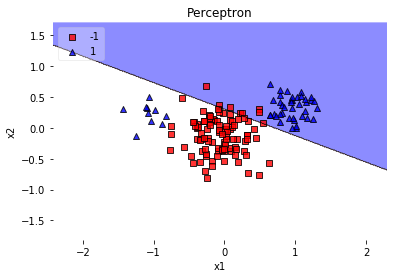

precision:
classA:0.8
classB:0.92


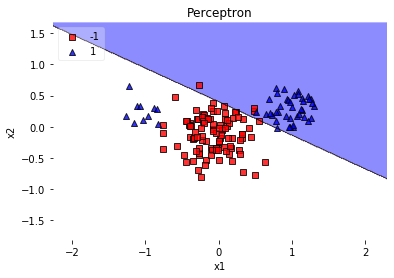

precision:
classA:0.8
classB:0.97


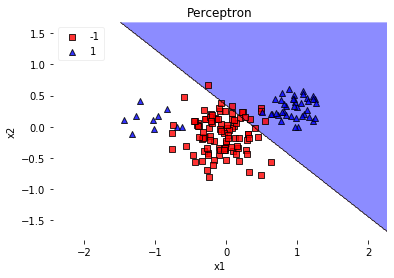

precision:
classA:0.8
classB:0.9


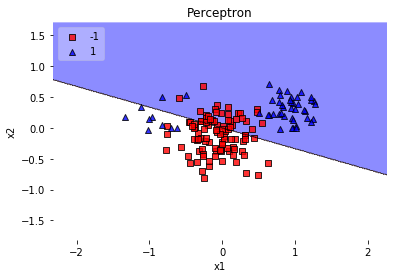

precision:
classA:0.84
classB:0.66


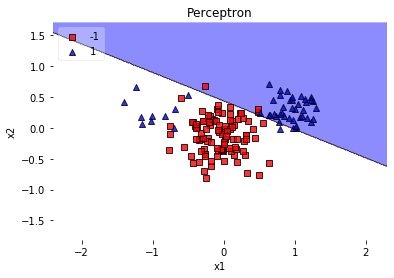

precision:
classA:0.78
classB:0.97


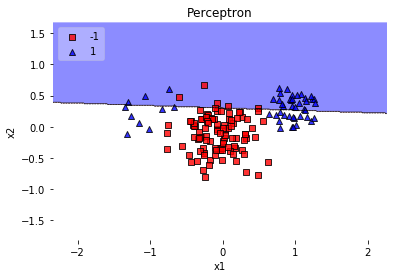

precision:
classA:0.54
classB:0.95


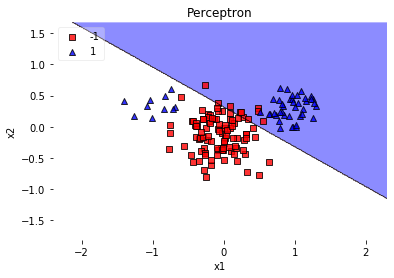

precision:
classA:0.8
classB:0.9


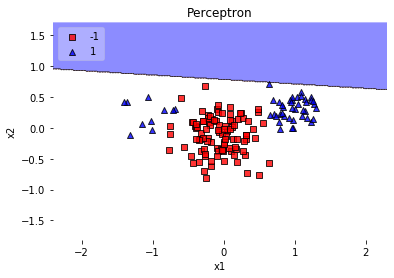

precision:
classA:0.0
classB:1.0


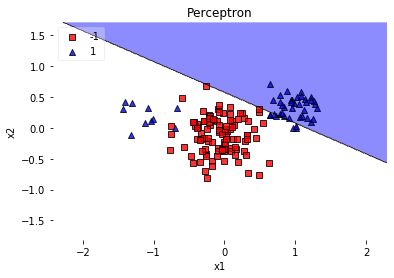

precision:
classA:0.66
classB:1.0


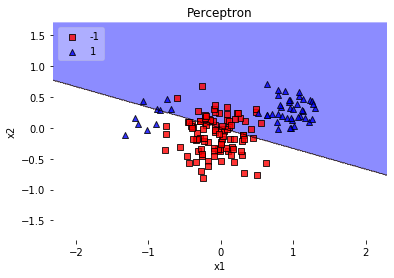

precision:
classA:0.9
classB:0.66


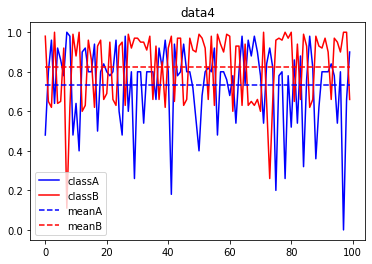

In [27]:
print('20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0')
Aleft = []
Aright = []
for a in classA:
    if a[0]<0:
        Aleft.append(a)
    else:
        Aright.append(a)
        
resultsA = []
resultsB = []

for ri in range(iters):
    np.random.shuffle(Aleft)
    A1 = Aleft[0:int(0.2*len(Aleft))]
    np.random.shuffle(Aright)
    A2 = Aright[0:int(0.8*len(Aright))]
    A = np.concatenate((A1,A2))
    B = classB
    np.random.shuffle(B)
    inputs = np.concatenate((A, B))
    targets = np.concatenate((np.ones(A.shape[0],dtype=int), -np.ones(B.shape[0],dtype=int)))
    N = inputs.shape[0]  # Number of rows (samples)
    permute = list(range(N))
    np.random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]

    X = inputs
    y = targets
    ppn = Perceptron(epochs=20, eta=0.01)
    ppn.train(X, y)
    plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
    plt.title('Perceptron')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('imgs/unseen_data4_eta{}_iter{}.png'.format(str(eta),ri))
    plt.show()
    a = 0
    b = 0
    for x,t in zip(inputs,targets):
        if ppn.predict(x)==t:
            if t == 1:
                a=a+1
            if t ==-1:
                b=b+1          
    print('precision:')
    print('classA:'+str(a/len(A)))
    print('classB:'+str(b/len(B)))
    resultsA.append(a/len(A))
    resultsB.append(b/len(B))
x = [i for i in range(iters)]
plt.plot(x,resultsA,'b-',label='classA')
plt.plot(x,resultsB,'r-',label='classB')
A_mean = [np.mean(resultsA)]*len(x)
B_mean = [np.mean(resultsB)]*len(x)
plt.plot(x,A_mean, label='meanA', linestyle='--',c='b')
plt.plot(x,B_mean, label='meanB', linestyle='--',c='r')
plt.legend()
plt.title('data4')
plt.savefig('imgs/data4_precision.png')
plt.show()
